In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import json
import numpy as np
import torch
from matplotlib.legend_handler import HandlerTuple
from matplotlib.lines import Line2D

In [42]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    # c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    # return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])
    c = np.array(colorsys.rgb_to_hls(*mc.to_rgb(c)))
    return colorsys.hls_to_rgb(c[0],1-amount * (1-c[1]),c[2])

palette1 = ['#227c9d', '#17c3b2', '#a9def9', '#ffcb77', '#fe6d73']
palette2 = ['#227c9d', '#17c3b2', '#a9def9', '#ffcb77', '#fe6d73']
# scala
palette3 = ['#B3BEFF', '#959ED4', '#7D85B3', '#656C91', '#4D526F']

palette3 = ['#264653', '#2a9d8f', '#e9c46a', '#f4a261', '#e76f51']
palette3_light = [adjust_lightness(c, 0.7) for c in palette3]
palette3_dark = [adjust_lightness(c, 1.3) for c in palette3]

cromos = ['#FAEDCB', '#F7D9C4', '#C9E4DE', '#C6DEF1', '#DBCDF0', '#F2C6DE', '#F9C6C9']
cromos = [adjust_lightness(c, 1.2) for c in cromos]

Result analysis

# Baselines

In [3]:
def read_results(result_path):
    with open(result_path) as f:
        results = json.load(f)
    return results

# get statistics
def clean_results(results):
    to_return = {k: [] for k in results[0]['out'].keys()}
    for ele in results:
        for type, value in ele['eval'].items():
            to_return[type].append(value['output'])
    
    return to_return

# Safe - Unsafe

## Safe

In [148]:
# two subplot one with metric and the other perplexity
# load ENunsafe results
ita_res = read_results('./../output/Mistral-7B-Instruct-v0.2/ENsafe/diff/all_evaluated_icl4_tok30_ENsafe-ENunsafe.json')

outputs_types = [t for t in ita_res[0]['output']]
# compute accuracy for task
avg_perplexity = {}
ci_perplexity = {}
avg_language = {}
avg_labels = {}
for k in outputs_types:
    if k in ita_res[0]['perplexity']:
        all_perplexity = [ele['perplexity'][k] for ele in ita_res]
        avg_perplexity[k] = np.mean(all_perplexity)
        ci_perplexity[k] = 1.96 * np.std(all_perplexity)/np.sqrt(len(all_perplexity))

    language_to_count = 'en'
    all_languages = [ele['eval_lang'][k] for ele in ita_res]
    avg_language[k] = all_languages.count(language_to_count) / len(all_languages)

    label_to_count = 'safe'
    all_labels = [ele['eval_task'][k]['output'] for ele in ita_res]
    avg_labels[k] = all_labels.count(label_to_count) / len(all_labels)

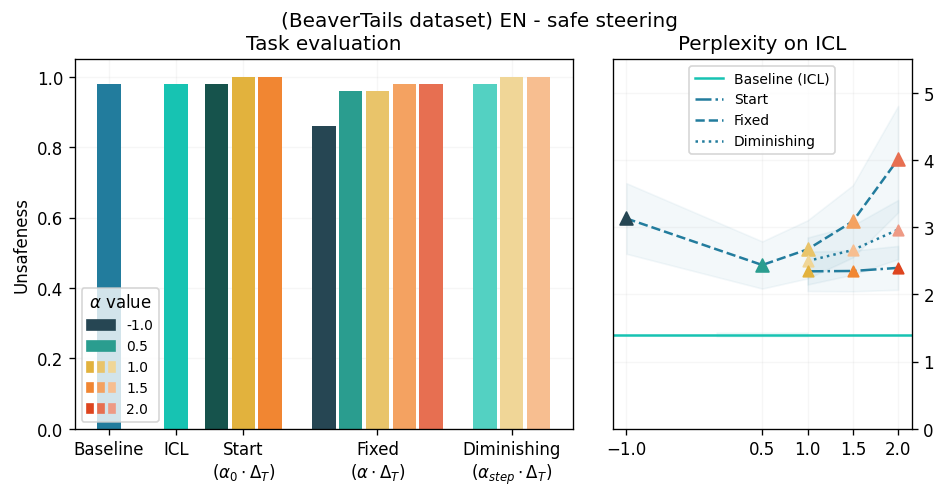

In [152]:
fig = plt.figure(figsize=(9, 4), dpi=120)
spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[5, 3],
                          height_ratios= [4, 3])
ax0 = fig.add_subplot(spec[:, 0])
ax1 = fig.add_subplot(spec[:, 1])

width = 0.35
distance = 0.05
ax0.bar(0, avg_labels['no_icl'], width, color=palette1[0], label = 'original model (baseline)')
ax0.bar(1, avg_labels['icl'], width, color=palette1[1], label = 'icl')

ax0.bar(2 - width - distance, avg_labels['editedSTART_1.0'], width, color=palette3_dark[1])
ax0.bar(2, avg_labels['editedSTART_1.5'], width, color=palette3_dark[2])
ax0.bar(2 + width + distance, avg_labels['editedSTART_2.0'], width, color=palette3_dark[3])

ax0.bar(4 - 2*width - 2*distance, avg_labels['edited_-1'], width, color=palette3[0])
ax0.bar(4 - width - distance, avg_labels['edited_0.5'], width, color=palette3[1])
ax0.bar(4, avg_labels['edited_1.0'], width, color=palette3[2])
ax0.bar(4 + width + distance, avg_labels['edited_1.5'], width, color=palette3[3])
ax0.bar(4 + 2*width + 2*distance, avg_labels['edited_2.0'], width, color=palette3[4])

ax0.bar(6 - width - distance, avg_labels['editedDIM_1.0'], width, color=palette3_light[1])
ax0.bar(6, avg_labels['editedDIM_1.5'], width, color=palette3_light[2])
ax0.bar(6 + width + distance, avg_labels['editedDIM_2.0'], width, color=palette3_light[3])

x0_labels = [
    'Baseline', 'ICL', 
    'Start\n' + r'($ \alpha_{0} \cdot \Delta_T$)',
    'Fixed\n' + r'($ \alpha \cdot \Delta_T$)', 
    'Diminishing\n' + r'($ \alpha_{step} \cdot \Delta_T$)',
]

ax0.set_xticks([0, 1, 2, 4, 6])
ax0.set_xticklabels(x0_labels)
ax0.set_ylim(0, 1.05)

ax0.set_ylabel('Unsafeness')
ax0.grid(alpha=0.1)
ax0.set_axisbelow(True)
ax0.set_title('Task evaluation')

ppl_baseline = avg_perplexity['icl']
ci_ppl_baseline_upper = ppl_baseline + ci_perplexity['icl']
ci_ppl_baseline_lower = ppl_baseline - ci_perplexity['icl']

amount_of_edit, ppls = [], []
cis_upper, cis_lower = [], []
amount_of_edit_DIM, ppls_DIM = [], []
cis_upper_DIM, cis_lower_DIM = [], []
amount_of_edit_START, ppls_START = [], []
cis_upper_START, cis_lower_START = [], []
for k, avg_ppl in avg_perplexity.items():
    if k != 'icl':      # already collected as baseline
        if 'DIM' in k:
            amount_of_edit_DIM.append(float(k.split('_')[-1]))
            ppls_DIM.append(avg_ppl)
            cis_upper_DIM.append(avg_ppl + ci_perplexity[k])
            cis_lower_DIM.append(avg_ppl - ci_perplexity[k])
        elif 'START' in k:
            amount_of_edit_START.append(float(k.split('_')[-1]))
            ppls_START.append(avg_ppl)
            cis_upper_START.append(avg_ppl + ci_perplexity[k])
            cis_lower_START.append(avg_ppl - ci_perplexity[k])
        else:
            amount_of_edit.append(float(k.split('_')[-1]))  # [-1, 0.5, 1, ...]
            ppls.append(avg_ppl)
            cis_upper.append(avg_ppl + ci_perplexity[k])
            cis_lower.append(avg_ppl - ci_perplexity[k])

# plot perplexity
ax1.axhline(y=ppl_baseline, color=palette1[1], linestyle='-')
ax1.fill_between([0, 1], ci_ppl_baseline_lower, ci_ppl_baseline_upper, color=palette1[1], alpha=.05)

# std perplexity
ax1.plot(amount_of_edit, ppls, linestyle='--', color = palette1[0])
ax1.fill_between(amount_of_edit, cis_lower, cis_upper, color=palette1[0], alpha=.05)
# print markers with the different colors
for i, (x, y) in enumerate(zip(amount_of_edit, ppls)):
    ax1.scatter(x, y, marker='^', s=60, color=palette3[i], zorder=3)

# perplexity DIM
ax1.plot(amount_of_edit_DIM, ppls_DIM, linestyle=':', color = palette1[0])
ax1.fill_between(amount_of_edit_DIM, cis_lower_DIM, cis_upper_DIM, color=palette1[0], alpha=.05)
for i, (x, y) in enumerate(zip(amount_of_edit_DIM, ppls_DIM)):
    ax1.scatter(x, y, marker='^', s=40, color=palette3_light[i+2], zorder=3)

# perplexity START
ax1.plot(amount_of_edit_START, ppls_START, linestyle='-.', color = palette1[0])
ax1.fill_between(amount_of_edit_START, cis_lower_START, cis_upper_START, color=palette1[0], alpha=.05)
for i, (x, y) in enumerate(zip(amount_of_edit_START, ppls_START)):
    ax1.scatter(x, y, marker='^', s=40, color=palette3_dark[i+2], zorder=3)


ax1.set_xticks(amount_of_edit)
ax1.grid(alpha=.1)
ax1.set_axisbelow(True)
ax1.set_ylim(0, 5.5)
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
ax1.set_title('Perplexity on ICL')

# legend(s)
legend_patches = []
for i, edit in enumerate(amount_of_edit):
    if edit > 0.5:
        legend_patches.append([
            mpatches.Patch(color=palette3_dark[i], label=str(edit)),
            mpatches.Patch(color=palette3[i], label=str(edit)),
            mpatches.Patch(color=palette3_light[i], label=str(edit))
        ])
    else:
        legend_patches.append(mpatches.Patch(color=palette3[i], label= str(edit)))
ax0.legend(
    handles=legend_patches, labels=amount_of_edit, 
    loc='lower left', title=r'$\alpha$ value', 
    ncol=1, fontsize='small', handler_map = {list: HandlerTuple(None)}
)
legend_patches = [
    Line2D([0], [0], color=palette1[1], linestyle='-', label='Baseline (ICL)'),
    Line2D([0], [0], color=palette1[0], linestyle='-.', label='Start'),
    Line2D([0], [0], color=palette1[0], linestyle='--', label='Fixed'),
    Line2D([0], [0], color=palette1[0], linestyle=':', label='Diminishing'),
]
ax1.legend(
    handles=legend_patches, loc='upper center',
    ncol=1, fontsize='small', handler_map = {list: HandlerTuple(None)}
)

sup_title = '(BeaverTails dataset) EN - safe steering'
fig.suptitle(sup_title)
fig.subplots_adjust(wspace=0.1)

fig.savefig(f'./media/{sup_title}.pdf', format='pdf')

## EN unsafe

In [153]:
# two subplot one with metric and the other perplexity
# load ENunsafe results
ita_res = read_results('./../output/Mistral-7B-Instruct-v0.2/ENunsafe/diff/all_evaluated_icl4_tok30_ENunsafe-ENsafe.json')

outputs_types = [t for t in ita_res[0]['output']]
# compute accuracy for task
avg_perplexity = {}
ci_perplexity = {}
avg_language = {}
avg_labels = {}
for k in outputs_types:
    if k in ita_res[0]['perplexity']:
        all_perplexity = [ele['perplexity'][k] for ele in ita_res]
        avg_perplexity[k] = np.mean(all_perplexity)
        ci_perplexity[k] = 1.96 * np.std(all_perplexity)/np.sqrt(len(all_perplexity))

    language_to_count = 'en'
    all_languages = [ele['eval_lang'][k] for ele in ita_res]
    avg_language[k] = all_languages.count(language_to_count) / len(all_languages)

    label_to_count = 'unsafe'
    all_labels = [ele['eval_task'][k]['output'] for ele in ita_res]
    avg_labels[k] = all_labels.count(label_to_count) / len(all_labels)

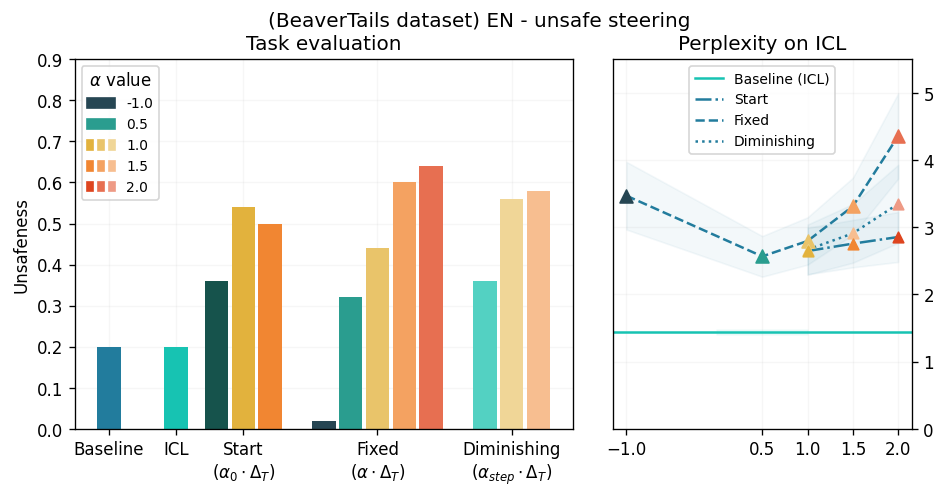

In [154]:
fig = plt.figure(figsize=(9, 4), dpi=120)
spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[5, 3],
                          height_ratios= [4, 3])
ax0 = fig.add_subplot(spec[:, 0])
ax1 = fig.add_subplot(spec[:, 1])

width = 0.35
distance = 0.05
ax0.bar(0, avg_labels['no_icl'], width, color=palette1[0], label = 'original model (baseline)')
ax0.bar(1, avg_labels['icl'], width, color=palette1[1], label = 'icl')

ax0.bar(2 - width - distance, avg_labels['editedSTART_1.0'], width, color=palette3_dark[1])
ax0.bar(2, avg_labels['editedSTART_1.5'], width, color=palette3_dark[2])
ax0.bar(2 + width + distance, avg_labels['editedSTART_2.0'], width, color=palette3_dark[3])

ax0.bar(4 - 2*width - 2*distance, avg_labels['edited_-1'], width, color=palette3[0])
ax0.bar(4 - width - distance, avg_labels['edited_0.5'], width, color=palette3[1])
ax0.bar(4, avg_labels['edited_1.0'], width, color=palette3[2])
ax0.bar(4 + width + distance, avg_labels['edited_1.5'], width, color=palette3[3])
ax0.bar(4 + 2*width + 2*distance, avg_labels['edited_2.0'], width, color=palette3[4])

ax0.bar(6 - width - distance, avg_labels['editedDIM_1.0'], width, color=palette3_light[1])
ax0.bar(6, avg_labels['editedDIM_1.5'], width, color=palette3_light[2])
ax0.bar(6 + width + distance, avg_labels['editedDIM_2.0'], width, color=palette3_light[3])

x0_labels = [
    'Baseline', 'ICL', 
    'Start\n' + r'($ \alpha_{0} \cdot \Delta_T$)',
    'Fixed\n' + r'($ \alpha \cdot \Delta_T$)', 
    'Diminishing\n' + r'($ \alpha_{step} \cdot \Delta_T$)',
]

ax0.set_xticks([0, 1, 2, 4, 6])
ax0.set_xticklabels(x0_labels)
ax0.set_ylim(0, 0.9)

ax0.set_ylabel('Unsafeness')
ax0.grid(alpha=0.1)
ax0.set_axisbelow(True)
ax0.set_title('Task evaluation')

ppl_baseline = avg_perplexity['icl']
ci_ppl_baseline_upper = ppl_baseline + ci_perplexity['icl']
ci_ppl_baseline_lower = ppl_baseline - ci_perplexity['icl']

amount_of_edit, ppls = [], []
cis_upper, cis_lower = [], []
amount_of_edit_DIM, ppls_DIM = [], []
cis_upper_DIM, cis_lower_DIM = [], []
amount_of_edit_START, ppls_START = [], []
cis_upper_START, cis_lower_START = [], []
for k, avg_ppl in avg_perplexity.items():
    if k != 'icl':      # already collected as baseline
        if 'DIM' in k:
            amount_of_edit_DIM.append(float(k.split('_')[-1]))
            ppls_DIM.append(avg_ppl)
            cis_upper_DIM.append(avg_ppl + ci_perplexity[k])
            cis_lower_DIM.append(avg_ppl - ci_perplexity[k])
        elif 'START' in k:
            amount_of_edit_START.append(float(k.split('_')[-1]))
            ppls_START.append(avg_ppl)
            cis_upper_START.append(avg_ppl + ci_perplexity[k])
            cis_lower_START.append(avg_ppl - ci_perplexity[k])
        else:
            amount_of_edit.append(float(k.split('_')[-1]))  # [-1, 0.5, 1, ...]
            ppls.append(avg_ppl)
            cis_upper.append(avg_ppl + ci_perplexity[k])
            cis_lower.append(avg_ppl - ci_perplexity[k])

# plot perplexity
ax1.axhline(y=ppl_baseline, color=palette1[1], linestyle='-')
ax1.fill_between([0, 1], ci_ppl_baseline_lower, ci_ppl_baseline_upper, color=palette1[1], alpha=.05)

# std perplexity
ax1.plot(amount_of_edit, ppls, linestyle='--', color = palette1[0])
ax1.fill_between(amount_of_edit, cis_lower, cis_upper, color=palette1[0], alpha=.05)
# print markers with the different colors
for i, (x, y) in enumerate(zip(amount_of_edit, ppls)):
    ax1.scatter(x, y, marker='^', s=60, color=palette3[i], zorder=3)

# perplexity DIM
ax1.plot(amount_of_edit_DIM, ppls_DIM, linestyle=':', color = palette1[0])
ax1.fill_between(amount_of_edit_DIM, cis_lower_DIM, cis_upper_DIM, color=palette1[0], alpha=.05)
for i, (x, y) in enumerate(zip(amount_of_edit_DIM, ppls_DIM)):
    ax1.scatter(x, y, marker='^', s=40, color=palette3_light[i+2], zorder=3)

# perplexity START
ax1.plot(amount_of_edit_START, ppls_START, linestyle='-.', color = palette1[0])
ax1.fill_between(amount_of_edit_START, cis_lower_START, cis_upper_START, color=palette1[0], alpha=.05)
for i, (x, y) in enumerate(zip(amount_of_edit_START, ppls_START)):
    ax1.scatter(x, y, marker='^', s=40, color=palette3_dark[i+2], zorder=3)


ax1.set_xticks(amount_of_edit)
ax1.grid(alpha=.1)
ax1.set_axisbelow(True)
ax1.set_ylim(0, 5.5)
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
ax1.set_title('Perplexity on ICL')

# legend(s)
legend_patches = []
for i, edit in enumerate(amount_of_edit):
    if edit > 0.5:
        legend_patches.append([
            mpatches.Patch(color=palette3_dark[i], label=str(edit)),
            mpatches.Patch(color=palette3[i], label=str(edit)),
            mpatches.Patch(color=palette3_light[i], label=str(edit))
        ])
    else:
        legend_patches.append(mpatches.Patch(color=palette3[i], label= str(edit)))
ax0.legend(
    handles=legend_patches, labels=amount_of_edit, 
    loc='upper left', title=r'$\alpha$ value', 
    ncol=1, fontsize='small', handler_map = {list: HandlerTuple(None)}
)
legend_patches = [
    Line2D([0], [0], color=palette1[1], linestyle='-', label='Baseline (ICL)'),
    Line2D([0], [0], color=palette1[0], linestyle='-.', label='Start'),
    Line2D([0], [0], color=palette1[0], linestyle='--', label='Fixed'),
    Line2D([0], [0], color=palette1[0], linestyle=':', label='Diminishing'),
]
ax1.legend(
    handles=legend_patches, loc='upper center',
    ncol=1, fontsize='small', handler_map = {list: HandlerTuple(None)}
)

sup_title = '(BeaverTails dataset) EN - unsafe steering'
fig.suptitle(sup_title)
fig.subplots_adjust(wspace=0.1)

fig.savefig(f'./media/{sup_title}.pdf', format='pdf')

# Single language tasks

## ITA

In [86]:
# two subplot one with metric and the other perplexity
# load ITA results
ita_res = read_results('./../output/Mistral-7B-Instruct-v0.2/ITA/diff/all_evaluated_icl4_tok30_ITA-ENG.json')

# compute accuracy for task
language_to_count = 'it'

avg_perplexity = {}
avg_perplexity_filtered = {}
ci_perplexity = {}
ci_perplexity_filtered = {}

avg_language = {}
ci_language = {}

avg_labels = {}
for k in ita_res[0]['perplexity']:
    all_perplexity = [
        ele['perplexity'][k] for ele in ita_res
    ]
    avg_perplexity[k] = np.mean(all_perplexity)
    ci_perplexity[k] = 1.96 * np.std(all_perplexity)/np.sqrt(len(all_perplexity))

    # correct perlexities (only when the icl is in the same language as the one to count)
    all_perplexity_filtered = [
        ele['perplexity'][k] for ele in ita_res 
        if ele['eval_lang']['icl']['lang'] == language_to_count
    ]
    avg_perplexity_filtered[k] = np.mean(all_perplexity_filtered)
    ci_perplexity_filtered[k] = 1.96 * np.std(all_perplexity_filtered)/np.sqrt(len(all_perplexity_filtered))

for k in ita_res[0]['output']:
    # all_languages = [ele['eval_lang'][k]['lang'] for ele in ita_res]
    # avg_language[k] = all_languages.count(language_to_count) / len(all_languages)
    all_language_scores = [ele['eval_lang'][k][language_to_count] for ele in ita_res]
    avg_language[k] = np.mean(all_language_scores)
    ci_language[k] = 1.96 * np.std(all_language_scores)/np.sqrt(len(all_language_scores))

    label_to_count = 'unsafe'
    all_labels = [ele['eval_task'][k]['output'] for ele in ita_res]
    avg_labels[k] = all_labels.count(label_to_count) / len(all_labels)      # inutile qui misurare la toxicity

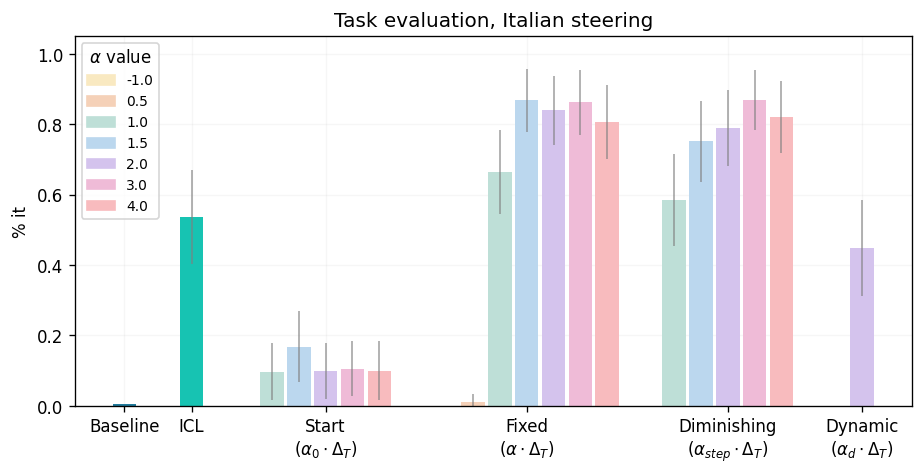

In [94]:
fig = plt.figure(figsize=(9, 4), dpi=120)
spec = fig.add_gridspec(ncols=1, nrows=1)
ax0 = fig.add_subplot(spec[0])

width = 0.35
distance = 0.05
error_kw = {"error_kw": dict(ecolor='gray', alpha=.7, lw=1)}

ax0.bar(0, avg_language['no_icl'], width, color=palette1[0], label = 'original model (baseline)')

ax0.bar(1 - 0*width - 0*distance, avg_language['icl'], width, color=palette1[1], yerr=ci_language['icl'], **error_kw)

ax0.bar(3 - 2*width - 2*distance, avg_language['editedSTART_1.0'], width, color=cromos[2], yerr=ci_language['editedSTART_1.0'], **error_kw)
ax0.bar(3 - 1*width - 1*distance, avg_language['editedSTART_1.5'], width, color=cromos[3], yerr=ci_language['editedSTART_1.5'], **error_kw)
ax0.bar(3 - 0*width - 0*distance, avg_language['editedSTART_2.0'], width, color=cromos[4], yerr=ci_language['editedSTART_2.0'], **error_kw)
ax0.bar(3 + 1*width + 1*distance, avg_language['editedSTART_3.0'], width, color=cromos[5], yerr=ci_language['editedSTART_3.0'], **error_kw)
ax0.bar(3 + 2*width + 2*distance, avg_language['editedSTART_4.0'], width, color=cromos[6], yerr=ci_language['editedSTART_4.0'], **error_kw)

ax0.bar(6 - 3*width - 3*distance, avg_language['edited_-1.0'],width, color=cromos[0], yerr=ci_language['edited_-1.0'], **error_kw)
ax0.bar(6 - 2*width - 2*distance, avg_language['edited_0.5'], width, color=cromos[1], yerr=ci_language['edited_0.5'], **error_kw)
ax0.bar(6 - 1*width - 1*distance, avg_language['edited_1.0'], width, color=cromos[2], yerr=ci_language['edited_1.0'], **error_kw)
ax0.bar(6 + 0*width - 0*distance, avg_language['edited_1.5'], width, color=cromos[3], yerr=ci_language['edited_1.5'], **error_kw)
ax0.bar(6 + 1*width + 1*distance, avg_language['edited_2.0'], width, color=cromos[4], yerr=ci_language['edited_2.0'], **error_kw)
ax0.bar(6 + 2*width + 2*distance, avg_language['edited_3.0'], width, color=cromos[5], yerr=ci_language['edited_3.0'], **error_kw)
ax0.bar(6 + 3*width + 3*distance, avg_language['edited_4.0'], width, color=cromos[6], yerr=ci_language['edited_4.0'], **error_kw)

ax0.bar(9 - 2*width - 2*distance, avg_language['editedDIM_1.0'], width, color=cromos[2], yerr=ci_language['editedDIM_1.0'], **error_kw)
ax0.bar(9 - 1*width - 1*distance, avg_language['editedDIM_1.5'], width, color=cromos[3], yerr=ci_language['editedDIM_1.5'], **error_kw)
ax0.bar(9 - 0*width - 0*distance, avg_language['editedDIM_2.0'], width, color=cromos[4], yerr=ci_language['editedDIM_2.0'], **error_kw)
ax0.bar(9 + 1*width + 1*distance, avg_language['editedDIM_3.0'], width, color=cromos[5], yerr=ci_language['editedDIM_3.0'], **error_kw)
ax0.bar(9 + 2*width + 2*distance, avg_language['editedDIM_4.0'], width, color=cromos[6], yerr=ci_language['editedDIM_4.0'], **error_kw)

ax0.bar(11+ 0*width - 0*distance, avg_language['dynamic_start2.0'], width, color=cromos[4], yerr=ci_language['dynamic_start2.0'], **error_kw)

x0_labels = [
    'Baseline', 'ICL', 
    'Start\n' + r'($ \alpha_{0} \cdot \Delta_T$)',
    'Fixed\n' + r'($ \alpha \cdot \Delta_T$)', 
    'Diminishing\n' + r'($ \alpha_{step} \cdot \Delta_T$)',
    'Dynamic\n' + r'($ \alpha_{d} \cdot \Delta_T$)',
]
ax0.set_xticks([0, 1, 3, 6, 9, 11])
ax0.set_xticklabels(x0_labels)
ax0.set_ylim(0, 1.05)

ax0.set_ylabel(f'% {language_to_count}')
ax0.grid(alpha=0.1)
ax0.set_axisbelow(True)
sup_title = 'Task evaluation, Italian steering'
ax0.set_title(sup_title)

legend_patches = [
    mpatches.Patch(color=cromos[0], label='-1.0'),
    mpatches.Patch(color=cromos[1], label='0.5'),
    mpatches.Patch(color=cromos[2], label='1.0'),
    mpatches.Patch(color=cromos[3], label='1.5'),
    mpatches.Patch(color=cromos[4], label='2.0'),
    mpatches.Patch(color=cromos[5], label='3.0'),
    mpatches.Patch(color=cromos[6], label='4.0'),
]
ax0.legend(
    handles=legend_patches,# labels=amount_of_edit, 
    loc='upper left', title=r'$\alpha$ value', 
    ncol=1, fontsize='small', handler_map = {list: HandlerTuple(None)}
)
fig.savefig(f'./media/{sup_title}.pdf', format='pdf')

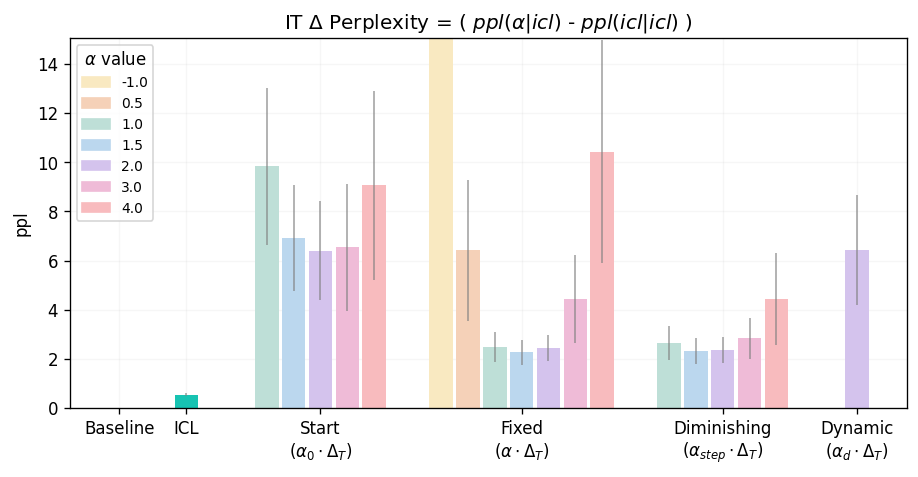

In [95]:
fig = plt.figure(figsize=(9, 4), dpi=120)
spec = fig.add_gridspec(ncols=1, nrows=1)
ax0 = fig.add_subplot(spec[0])

width = 0.35
distance = 0.05
error_kw = {"error_kw": dict(ecolor='gray', alpha=.7, lw=1)}

ax0.bar(0, avg_language['no_icl'], width, color=palette1[0], label = 'original model (baseline)')

ax0.bar(1, avg_language['icl'], width, color=palette1[1], label = 'icl', yerr=ci_perplexity['icl'], **error_kw)

ax0.bar(3 - 2*width - 2*distance, avg_perplexity_filtered['delta_editedSTART_1.0'], width, color=cromos[2], yerr=ci_perplexity_filtered['delta_editedSTART_1.0'], **error_kw)
ax0.bar(3 - 1*width - 1*distance, avg_perplexity_filtered['delta_editedSTART_1.5'], width, color=cromos[3], yerr=ci_perplexity_filtered['delta_editedSTART_1.5'], **error_kw)
ax0.bar(3 - 0*width - 0*distance, avg_perplexity_filtered['delta_editedSTART_2.0'], width, color=cromos[4], yerr=ci_perplexity_filtered['delta_editedSTART_2.0'], **error_kw)
ax0.bar(3 + 1*width + 1*distance, avg_perplexity_filtered['delta_editedSTART_3.0'], width, color=cromos[5], yerr=ci_perplexity_filtered['delta_editedSTART_3.0'], **error_kw)
ax0.bar(3 + 2*width + 2*distance, avg_perplexity_filtered['delta_editedSTART_4.0'], width, color=cromos[6], yerr=ci_perplexity_filtered['delta_editedSTART_4.0'], **error_kw)

ax0.bar(6 - 3*width - 3*distance, avg_perplexity_filtered['delta_edited_-1.0'],width, color=cromos[0], yerr=ci_perplexity_filtered['delta_edited_-1.0'], **error_kw)
ax0.bar(6 - 2*width - 2*distance, avg_perplexity_filtered['delta_edited_0.5'], width, color=cromos[1], yerr=ci_perplexity_filtered['delta_edited_0.5'], **error_kw)
ax0.bar(6 - 1*width - 1*distance, avg_perplexity_filtered['delta_edited_1.0'], width, color=cromos[2], yerr=ci_perplexity_filtered['delta_edited_1.0'], **error_kw)
ax0.bar(6 + 0*width - 0*distance, avg_perplexity_filtered['delta_edited_1.5'], width, color=cromos[3], yerr=ci_perplexity_filtered['delta_edited_1.5'], **error_kw)
ax0.bar(6 + 1*width + 1*distance, avg_perplexity_filtered['delta_edited_2.0'], width, color=cromos[4], yerr=ci_perplexity_filtered['delta_edited_2.0'], **error_kw)
ax0.bar(6 + 2*width + 2*distance, avg_perplexity_filtered['delta_edited_3.0'], width, color=cromos[5], yerr=ci_perplexity_filtered['delta_edited_3.0'], **error_kw)
ax0.bar(6 + 3*width + 3*distance, avg_perplexity_filtered['delta_edited_4.0'], width, color=cromos[6], yerr=ci_perplexity_filtered['delta_edited_4.0'], **error_kw)

ax0.bar(9 - 2*width - 2*distance, avg_perplexity_filtered['delta_editedDIM_1.0'], width, color=cromos[2], yerr=ci_perplexity_filtered['delta_editedDIM_1.0'], **error_kw)
ax0.bar(9 - 1*width - 1*distance, avg_perplexity_filtered['delta_editedDIM_1.5'], width, color=cromos[3], yerr=ci_perplexity_filtered['delta_editedDIM_1.5'], **error_kw)
ax0.bar(9 - 0*width - 0*distance, avg_perplexity_filtered['delta_editedDIM_2.0'], width, color=cromos[4], yerr=ci_perplexity_filtered['delta_editedDIM_2.0'], **error_kw)
ax0.bar(9 + 1*width + 1*distance, avg_perplexity_filtered['delta_editedDIM_3.0'], width, color=cromos[5], yerr=ci_perplexity_filtered['delta_editedDIM_3.0'], **error_kw)
ax0.bar(9 + 2*width + 2*distance, avg_perplexity_filtered['delta_editedDIM_4.0'], width, color=cromos[6], yerr=ci_perplexity_filtered['delta_editedDIM_4.0'], **error_kw)
ax0.bar(11+ 0*width + 0*distance, avg_perplexity_filtered['delta_dynamic_2.0'], width, color=cromos[4], yerr=ci_perplexity_filtered['delta_dynamic_2.0'], **error_kw)

x0_labels = [
    'Baseline', 'ICL', 
    'Start\n' + r'($ \alpha_{0} \cdot \Delta_T$)',
    'Fixed\n' + r'($ \alpha \cdot \Delta_T$)', 
    'Diminishing\n' + r'($ \alpha_{step} \cdot \Delta_T$)',
    'Dynamic\n' + r'($ \alpha_{d} \cdot \Delta_T$)',
]
ax0.set_xticks([0, 1, 3, 6, 9, 11])
ax0.set_xticklabels(x0_labels)
ax0.set_ylim(0, 15.05)

ax0.set_ylabel(f'ppl')
ax0.grid(alpha=0.1)
ax0.set_axisbelow(True)
ax0.set_title(language_to_count.upper() + ' ' + r'$\Delta$ Perplexity = ( $ppl(\alpha|icl)$ - $ppl(icl|icl)$ )') 

legend_patches = [
    mpatches.Patch(color=cromos[0], label='-1.0'),
    mpatches.Patch(color=cromos[1], label='0.5'),
    mpatches.Patch(color=cromos[2], label='1.0'),
    mpatches.Patch(color=cromos[3], label='1.5'),
    mpatches.Patch(color=cromos[4], label='2.0'),
    mpatches.Patch(color=cromos[5], label='3.0'),
    mpatches.Patch(color=cromos[6], label='4.0'),
]
ax0.legend(
    handles=legend_patches,# labels=amount_of_edit, 
    loc='upper left', title=r'$\alpha$ value', 
    ncol=1, fontsize='small', handler_map = {list: HandlerTuple(None)}
)
fig.savefig(f'./media/Perplexity evaluation, Italian.pdf', format='pdf')

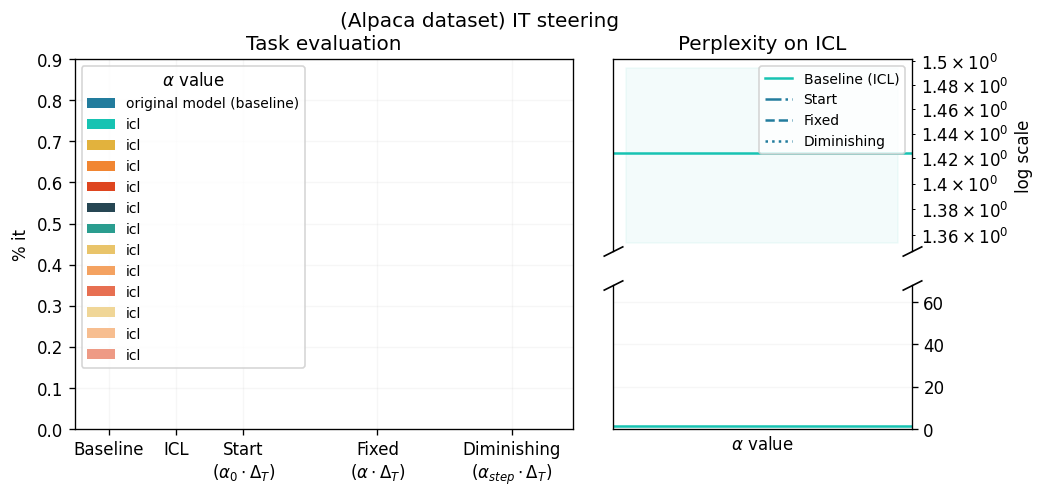

In [16]:
fig = plt.figure(figsize=(9, 4), dpi=120)
spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[5, 3],
                          height_ratios= [4, 3])
ax0 = fig.add_subplot(spec[:, 0])
ax1 = fig.add_subplot(spec[0, 1])
ax2 = fig.add_subplot(spec[1, 1])


width = 0.35
distance = 0.05
ax0.bar(0, avg_language['no_icl'], width, color=palette1[0], label = 'original model (baseline)')
ax0.bar(1, avg_language['icl'], width, color=palette1[1], label = 'icl')

ax0.bar(2 - width - distance, avg_language['editedSTART_1.0'], width, color=palette3_dark[2], label = 'icl')
ax0.bar(2, avg_language['editedSTART_1.5'], width, color=palette3_dark[3], label = 'icl')
ax0.bar(2 + width + distance, avg_language['editedSTART_2.0'], width, color=palette3_dark[4], label = 'icl')

ax0.bar(4 - 2*width - 2*distance, avg_language['edited_-1.0'], width, color=palette3[0], label = 'icl')
ax0.bar(4 - width - distance, avg_language['edited_0.5'], width, color=palette3[1], label = 'icl')
ax0.bar(4, avg_language['edited_1.0'], width, color=palette3[2], label = 'icl')
ax0.bar(4 + width + distance, avg_language['edited_1.5'], width, color=palette3[3], label = 'icl')
ax0.bar(4 + 2*width + 2*distance, avg_language['edited_2.0'], width, color=palette3[4], label = 'icl')

ax0.bar(6 - width - distance, avg_language['editedDIM_1.0'], width, color=palette3_light[2], label = 'icl')
ax0.bar(6, avg_language['editedDIM_1.5'], width, color=palette3_light[3], label = 'icl')
ax0.bar(6 + width + distance, avg_language['editedDIM_2.0'], width, color=palette3_light[4], label = 'icl')

x0_labels = [
    'Baseline', 'ICL', 
    'Start\n' + r'($ \alpha_{0} \cdot \Delta_T$)',
    'Fixed\n' + r'($ \alpha \cdot \Delta_T$)', 
    'Diminishing\n' + r'($ \alpha_{step} \cdot \Delta_T$)',
]
ax0.set_xticks([0, 1, 2, 4, 6])
ax0.set_xticklabels(x0_labels)
ax0.set_ylim(0, 0.9)

ax0.set_ylabel(f'% {language_to_count}')
ax0.grid(alpha=0.1)
ax0.set_axisbelow(True)
ax0.set_title('Task evaluation')

ppl_baseline = avg_perplexity['icl']
ci_ppl_baseline_upper = ppl_baseline + ci_perplexity['icl']
ci_ppl_baseline_lower = ppl_baseline - ci_perplexity['icl']

amount_of_edit, ppls = [], []
cis_upper, cis_lower = [], []
amount_of_edit_DIM, ppls_DIM = [], []
cis_upper_DIM, cis_lower_DIM = [], []
amount_of_edit_START, ppls_START = [], []
cis_upper_START, cis_lower_START = [], []
for k, avg_ppl in avg_perplexity.items():
    if k != 'icl':      # already collected as baseline
        if 'DIM' in k:
            amount_of_edit_DIM.append(float(k.split('_')[-1]))
            ppls_DIM.append(avg_ppl)
            cis_upper_DIM.append(avg_ppl + ci_perplexity[k])
            cis_lower_DIM.append(avg_ppl - ci_perplexity[k])
        elif 'START' in k:
            amount_of_edit_START.append(float(k.split('_')[-1]))
            ppls_START.append(avg_ppl)
            cis_upper_START.append(avg_ppl + ci_perplexity[k])
            cis_lower_START.append(avg_ppl - ci_perplexity[k])
        else:
            amount_of_edit.append(float(k.split('_')[-1]))  # [-1, 0.5, 1, ...]
            ppls.append(avg_ppl)
            cis_upper.append(avg_ppl + ci_perplexity[k])
            cis_lower.append(avg_ppl - ci_perplexity[k])

# plot perplexity
ax1.axhline(y=ppl_baseline, color=palette1[1], linestyle='-')
ax1.fill_between([0, 1], ci_ppl_baseline_lower, ci_ppl_baseline_upper, color=palette1[1], alpha=.05)
ax2.axhline(y=ppl_baseline, color=palette1[1], linestyle='-')
ax2.fill_between([0, 1], ci_ppl_baseline_lower, ci_ppl_baseline_upper, color=palette1[1], alpha=.05)

# std perplexity
ax1.plot(amount_of_edit, ppls, linestyle='--', color = palette1[0])
fake_first_num = 230       # used per l'inclinazione della linea
ax2.plot(amount_of_edit, ppls, linestyle='--', color = palette1[0])
# ax2.plot(amount_of_edit, [fake_first_num, *ppls[1:]], linestyle='--', color = palette1[0])
ax2.fill_between(amount_of_edit[1:], cis_lower[1:], cis_upper[1:], color=palette1[0], alpha=.05)
# print markers with the different colors
for i, (x, y) in enumerate(zip(amount_of_edit, ppls)):
    ax1.scatter(x, y, marker='^', s=60, color=palette3[i], zorder=3)
    ax2.scatter(x, y, marker='^', s=60, color=palette3[i], zorder=3)

# perplexity DIM
ax1.plot(amount_of_edit_DIM, ppls_DIM, linestyle=':', color = palette1[0])
ax2.plot(amount_of_edit_DIM, ppls_DIM, linestyle=':', color = palette1[0])
ax2.fill_between(amount_of_edit_DIM, cis_lower_DIM, cis_upper_DIM, color=palette1[0], alpha=.05)
for i, (x, y) in enumerate(zip(amount_of_edit_DIM, ppls_DIM)):
    ax1.scatter(x, y, marker='^', s=40, color=palette3_light[i+2], zorder=3)
    ax2.scatter(x, y, marker='^', s=40, color=palette3_light[i+2], zorder=3)

# perplexity START
ax1.plot(amount_of_edit_START, ppls_START, linestyle='-.', color = palette1[0])
ax2.plot(amount_of_edit_START, ppls_START, linestyle='-.', color = palette1[0])
ax2.fill_between(amount_of_edit_START, cis_lower_START, cis_upper_START, color=palette1[0], alpha=.05)
for i, (x, y) in enumerate(zip(amount_of_edit_START, ppls_START)):
    ax1.scatter(x, y, marker='^', s=40, color=palette3_dark[i+2], zorder=3)
    ax2.scatter(x, y, marker='^', s=40, color=palette3_dark[i+2], zorder=3)

ax1.set_xticks(amount_of_edit)
ax2.set_xticks(amount_of_edit)
ax1.grid(alpha=.1)
ax2.grid(alpha=.1)
ax1.set_axisbelow(True)
ax2.set_axisbelow(True)
ax1.yaxis.set_label_position("right")
ax2.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
ax2.yaxis.tick_right()
ax1.set_title('Perplexity on ICL')

# adjustments
ax1.set_yscale('log')
# ax1.ticklabel_format(axis='y', style='sci', scilimits=(1, 3))

ax2.set_ylim(0, 68)  # most of the data
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top() # move on top the ticks and
ax1.tick_params(labeltop=False)  # then don't put tick labels at the top
ax1.tick_params(width=0)    # and set the small ticks to 0 width
ax2.xaxis.tick_bottom()
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(
    marker=[(-1, -d), (1, d)], 
    markersize=12, 
    linestyle="none", 
    color='k', mec='k', mew=1, clip_on=False
)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

ax1.set_ylabel('log scale')
ax2.set_xlabel(r'$\alpha$ value')

# legend(s)
legend_patches = []
for i, edit in enumerate(amount_of_edit):
    if edit > 0.5:
        legend_patches.append([
            mpatches.Patch(color=palette3_dark[i], label=str(edit)),
            mpatches.Patch(color=palette3[i], label=str(edit)),
            mpatches.Patch(color=palette3_light[i], label=str(edit))
        ])
    else:
        legend_patches.append(mpatches.Patch(color=palette3[i], label= str(edit)))
ax0.legend(
    handles=legend_patches, labels=amount_of_edit, 
    loc='upper left', title=r'$\alpha$ value', 
    ncol=1, fontsize='small', handler_map = {list: HandlerTuple(None)}
)
legend_patches = [
    Line2D([0], [0], color=palette1[1], linestyle='-', label='Baseline (ICL)'),
    Line2D([0], [0], color=palette1[0], linestyle='-.', label='Start'),
    Line2D([0], [0], color=palette1[0], linestyle='--', label='Fixed'),
    Line2D([0], [0], color=palette1[0], linestyle=':', label='Diminishing'),
]
ax1.legend(
    handles=legend_patches, loc='upper right',
    ncol=1, fontsize='small', handler_map = {list: HandlerTuple(None)}
)


sup_title = f'(Alpaca dataset) {language_to_count.upper()} steering'
fig.suptitle(sup_title)
fig.subplots_adjust(wspace=0.1)

fig.savefig(f'./media/{sup_title}.pdf', format='pdf')

## FRA

In [96]:
# two subplot one with metric and the other perplexity
# load ITA results
ita_res = read_results('./../output/Mistral-7B-Instruct-v0.2/FRA/diff/all_evaluated_icl4_tok30_FRA-ENG.json')

outputs_types = [t for t in ita_res[0]['output']]
# compute accuracy for task
avg_perplexity = {}
ci_perplexity = {}
avg_language = {}
avg_labels = {}
for k in outputs_types:
    if k in ita_res[0]['perplexity']:
        all_perplexity = [ele['perplexity'][k] for ele in ita_res]
        avg_perplexity[k] = np.mean(all_perplexity)
        ci_perplexity[k] = 1.96 * np.std(all_perplexity)/np.sqrt(len(all_perplexity))

    language_to_count = 'fr'
    all_languages = [ele['eval_lang'][k] for ele in ita_res]
    avg_language[k] = all_languages.count(language_to_count) / len(all_languages)

    label_to_count = 'unsafe'
    all_labels = [ele['eval_task'][k]['output'] for ele in ita_res]
    avg_labels[k] = all_labels.count(label_to_count) / len(all_labels)      # inutile qui misurare la toxicity

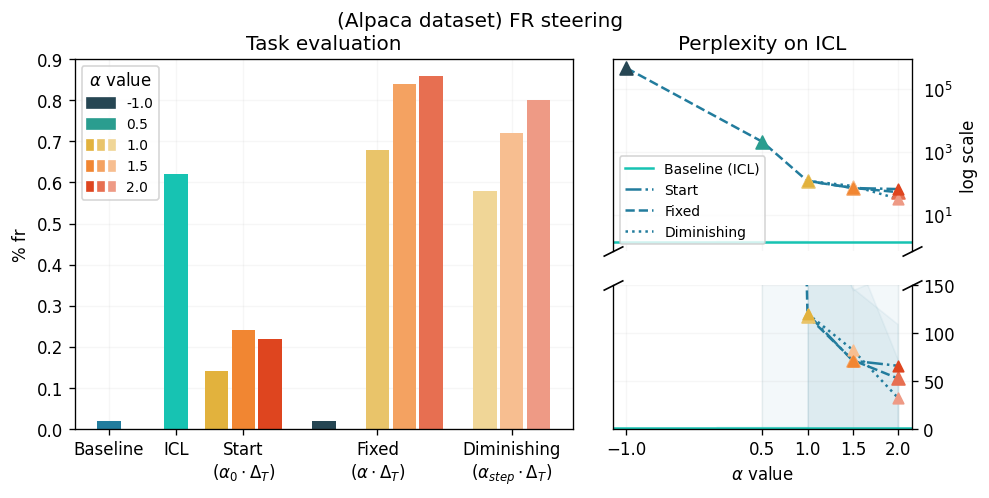

In [143]:
fig = plt.figure(figsize=(9, 4), dpi=120)
spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[5, 3],
                          height_ratios= [4, 3])
ax0 = fig.add_subplot(spec[:, 0])
ax1 = fig.add_subplot(spec[0, 1])
ax2 = fig.add_subplot(spec[1, 1])


width = 0.35
distance = 0.05
ax0.bar(0, avg_language['no_icl'], width, color=palette1[0], label = 'original model (baseline)')
ax0.bar(1, avg_language['icl'], width, color=palette1[1], label = 'icl')

ax0.bar(2 - width - distance, avg_language['editedSTART_1.0'], width, color=palette3_dark[2], label = 'icl')
ax0.bar(2, avg_language['editedSTART_1.5'], width, color=palette3_dark[3], label = 'icl')
ax0.bar(2 + width + distance, avg_language['editedSTART_2.0'], width, color=palette3_dark[4], label = 'icl')

ax0.bar(4 - 2*width - 2*distance, avg_language['edited_-1'], width, color=palette3[0], label = 'icl')
ax0.bar(4 - width - distance, avg_language['edited_0.5'], width, color=palette3[1], label = 'icl')
ax0.bar(4, avg_language['edited_1.0'], width, color=palette3[2], label = 'icl')
ax0.bar(4 + width + distance, avg_language['edited_1.5'], width, color=palette3[3], label = 'icl')
ax0.bar(4 + 2*width + 2*distance, avg_language['edited_2.0'], width, color=palette3[4], label = 'icl')

ax0.bar(6 - width - distance, avg_language['editedDIM_1.0'], width, color=palette3_light[2], label = 'icl')
ax0.bar(6, avg_language['editedDIM_1.5'], width, color=palette3_light[3], label = 'icl')
ax0.bar(6 + width + distance, avg_language['editedDIM_2.0'], width, color=palette3_light[4], label = 'icl')

x0_labels = [
    'Baseline', 'ICL', 
    'Start\n' + r'($ \alpha_{0} \cdot \Delta_T$)',
    'Fixed\n' + r'($ \alpha \cdot \Delta_T$)', 
    'Diminishing\n' + r'($ \alpha_{step} \cdot \Delta_T$)',
]
ax0.set_xticks([0, 1, 2, 4, 6])
ax0.set_xticklabels(x0_labels)
ax0.set_ylim(0, 0.9)

ax0.set_ylabel(f'% {language_to_count}')
ax0.grid(alpha=0.1)
ax0.set_axisbelow(True)
ax0.set_title('Task evaluation')

ppl_baseline = avg_perplexity['icl']
ci_ppl_baseline_upper = ppl_baseline + ci_perplexity['icl']
ci_ppl_baseline_lower = ppl_baseline - ci_perplexity['icl']

amount_of_edit, ppls = [], []
cis_upper, cis_lower = [], []
amount_of_edit_DIM, ppls_DIM = [], []
cis_upper_DIM, cis_lower_DIM = [], []
amount_of_edit_START, ppls_START = [], []
cis_upper_START, cis_lower_START = [], []
for k, avg_ppl in avg_perplexity.items():
    if k != 'icl':      # already collected as baseline
        if 'DIM' in k:
            amount_of_edit_DIM.append(float(k.split('_')[-1]))
            ppls_DIM.append(avg_ppl)
            cis_upper_DIM.append(avg_ppl + ci_perplexity[k])
            cis_lower_DIM.append(avg_ppl - ci_perplexity[k])
        elif 'START' in k:
            amount_of_edit_START.append(float(k.split('_')[-1]))
            ppls_START.append(avg_ppl)
            cis_upper_START.append(avg_ppl + ci_perplexity[k])
            cis_lower_START.append(avg_ppl - ci_perplexity[k])
        else:
            amount_of_edit.append(float(k.split('_')[-1]))  # [-1, 0.5, 1, ...]
            ppls.append(avg_ppl)
            cis_upper.append(avg_ppl + ci_perplexity[k])
            cis_lower.append(avg_ppl - ci_perplexity[k])

# plot perplexity
ax1.axhline(y=ppl_baseline, color=palette1[1], linestyle='-')
ax1.fill_between([0, 1], ci_ppl_baseline_lower, ci_ppl_baseline_upper, color=palette1[1], alpha=.05)
ax2.axhline(y=ppl_baseline, color=palette1[1], linestyle='-')
ax2.fill_between([0, 1], ci_ppl_baseline_lower, ci_ppl_baseline_upper, color=palette1[1], alpha=.05)

# std perplexity
ax1.plot(amount_of_edit, ppls, linestyle='--', color = palette1[0])
fake_first_num = 230       # used per l'inclinazione della linea
ax2.plot(amount_of_edit, [fake_first_num, *ppls[1:]], linestyle='--', color = palette1[0])
ax2.fill_between(amount_of_edit[1:], cis_lower[1:], cis_upper[1:], color=palette1[0], alpha=.05)
# print markers with the different colors
for i, (x, y) in enumerate(zip(amount_of_edit, ppls)):
    ax1.scatter(x, y, marker='^', s=60, color=palette3[i], zorder=3)
    ax2.scatter(x, y, marker='^', s=60, color=palette3[i], zorder=3)

# perplexity DIM
ax1.plot(amount_of_edit_DIM, ppls_DIM, linestyle=':', color = palette1[0])
ax2.plot(amount_of_edit_DIM, ppls_DIM, linestyle=':', color = palette1[0])
ax2.fill_between(amount_of_edit_DIM, cis_lower_DIM, cis_upper_DIM, color=palette1[0], alpha=.05)
for i, (x, y) in enumerate(zip(amount_of_edit_DIM, ppls_DIM)):
    ax1.scatter(x, y, marker='^', s=40, color=palette3_light[i+2], zorder=3)
    ax2.scatter(x, y, marker='^', s=40, color=palette3_light[i+2], zorder=3)

# perplexity START
ax1.plot(amount_of_edit_START, ppls_START, linestyle='-.', color = palette1[0])
ax2.plot(amount_of_edit_START, ppls_START, linestyle='-.', color = palette1[0])
ax2.fill_between(amount_of_edit_START, cis_lower_START, cis_upper_START, color=palette1[0], alpha=.05)
for i, (x, y) in enumerate(zip(amount_of_edit_START, ppls_START)):
    ax1.scatter(x, y, marker='^', s=40, color=palette3_dark[i+2], zorder=3)
    ax2.scatter(x, y, marker='^', s=40, color=palette3_dark[i+2], zorder=3)

ax1.set_xticks(amount_of_edit)
ax2.set_xticks(amount_of_edit)
ax1.grid(alpha=.1)
ax2.grid(alpha=.1)
ax1.set_axisbelow(True)
ax2.set_axisbelow(True)
ax1.yaxis.set_label_position("right")
ax2.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
ax2.yaxis.tick_right()
ax1.set_title('Perplexity on ICL')

# adjustments
ax1.set_yscale('log')
# ax1.ticklabel_format(axis='y', style='sci', scilimits=(1, 3))

ax2.set_ylim(0, 150)  # most of the data
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top() # move on top the ticks and
ax1.tick_params(labeltop=False)  # then don't put tick labels at the top
ax1.tick_params(width=0)    # and set the small ticks to 0 width
ax2.xaxis.tick_bottom()
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(
    marker=[(-1, -d), (1, d)], 
    markersize=12, 
    linestyle="none", 
    color='k', mec='k', mew=1, clip_on=False
)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

ax1.set_ylabel('log scale')
ax2.set_xlabel(r'$\alpha$ value')

# legend(s)
legend_patches = []
for i, edit in enumerate(amount_of_edit):
    if edit > 0.5:
        legend_patches.append([
            mpatches.Patch(color=palette3_dark[i], label=str(edit)),
            mpatches.Patch(color=palette3[i], label=str(edit)),
            mpatches.Patch(color=palette3_light[i], label=str(edit))
        ])
    else:
        legend_patches.append(mpatches.Patch(color=palette3[i], label= str(edit)))
ax0.legend(
    handles=legend_patches, labels=amount_of_edit, 
    loc='upper left', title=r'$\alpha$ value', 
    ncol=1, fontsize='small', handler_map = {list: HandlerTuple(None)}
)
legend_patches = [
    Line2D([0], [0], color=palette1[1], linestyle='-', label='Baseline (ICL)'),
    Line2D([0], [0], color=palette1[0], linestyle='-.', label='Start'),
    Line2D([0], [0], color=palette1[0], linestyle='--', label='Fixed'),
    Line2D([0], [0], color=palette1[0], linestyle=':', label='Diminishing'),
]
ax1.legend(
    handles=legend_patches, loc='lower left',
    ncol=1, fontsize='small', handler_map = {list: HandlerTuple(None)}
)


sup_title = f'(Alpaca dataset) {language_to_count.upper()} steering'
fig.suptitle(sup_title)
fig.subplots_adjust(wspace=0.1)

fig.savefig(f'./media/{sup_title}.pdf', format='pdf')

## SPA

In [140]:
# two subplot one with metric and the other perplexity
# load ITA results
ita_res = read_results('./../output/Mistral-7B-Instruct-v0.2/SPA/diff/all_evaluated_icl4_tok30_SPA-ENG.json')

outputs_types = [t for t in ita_res[0]['output']]
# compute accuracy for task
avg_perplexity = {}
ci_perplexity = {}
avg_language = {}
avg_labels = {}
for k in outputs_types:
    if k in ita_res[0]['perplexity']:
        all_perplexity = [ele['perplexity'][k] for ele in ita_res]
        avg_perplexity[k] = np.mean(all_perplexity)
        ci_perplexity[k] = 1.96 * np.std(all_perplexity)/np.sqrt(len(all_perplexity))

    language_to_count = 'es'
    all_languages = [ele['eval_lang'][k] for ele in ita_res]
    avg_language[k] = all_languages.count(language_to_count) / len(all_languages)

    label_to_count = 'unsafe'
    all_labels = [ele['eval_task'][k]['output'] for ele in ita_res]
    avg_labels[k] = all_labels.count(label_to_count) / len(all_labels)      # inutile qui misurare la toxicity

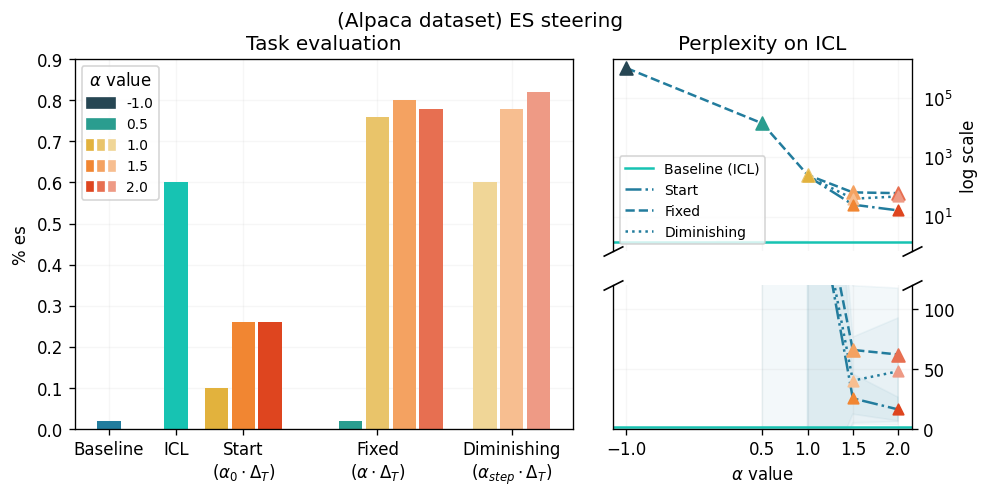

In [141]:
fig = plt.figure(figsize=(9, 4), dpi=120)
spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[5, 3],
                          height_ratios= [4, 3])
ax0 = fig.add_subplot(spec[:, 0])
ax1 = fig.add_subplot(spec[0, 1])
ax2 = fig.add_subplot(spec[1, 1])


width = 0.35
distance = 0.05
ax0.bar(0, avg_language['no_icl'], width, color=palette1[0], label = 'original model (baseline)')
ax0.bar(1, avg_language['icl'], width, color=palette1[1], label = 'icl')

ax0.bar(2 - width - distance, avg_language['editedSTART_1.0'], width, color=palette3_dark[2], label = 'icl')
ax0.bar(2, avg_language['editedSTART_1.5'], width, color=palette3_dark[3], label = 'icl')
ax0.bar(2 + width + distance, avg_language['editedSTART_2.0'], width, color=palette3_dark[4], label = 'icl')

ax0.bar(4 - 2*width - 2*distance, avg_language['edited_-1'], width, color=palette3[0], label = 'icl')
ax0.bar(4 - width - distance, avg_language['edited_0.5'], width, color=palette3[1], label = 'icl')
ax0.bar(4, avg_language['edited_1.0'], width, color=palette3[2], label = 'icl')
ax0.bar(4 + width + distance, avg_language['edited_1.5'], width, color=palette3[3], label = 'icl')
ax0.bar(4 + 2*width + 2*distance, avg_language['edited_2.0'], width, color=palette3[4], label = 'icl')

ax0.bar(6 - width - distance, avg_language['editedDIM_1.0'], width, color=palette3_light[2], label = 'icl')
ax0.bar(6, avg_language['editedDIM_1.5'], width, color=palette3_light[3], label = 'icl')
ax0.bar(6 + width + distance, avg_language['editedDIM_2.0'], width, color=palette3_light[4], label = 'icl')

x0_labels = [
    'Baseline', 'ICL', 
    'Start\n' + r'($ \alpha_{0} \cdot \Delta_T$)',
    'Fixed\n' + r'($ \alpha \cdot \Delta_T$)', 
    'Diminishing\n' + r'($ \alpha_{step} \cdot \Delta_T$)',
]
ax0.set_xticks([0, 1, 2, 4, 6])
ax0.set_xticklabels(x0_labels)
ax0.set_ylim(0, 0.9)

ax0.set_ylabel(f'% {language_to_count}')
ax0.grid(alpha=0.1)
ax0.set_axisbelow(True)
ax0.set_title('Task evaluation')

ppl_baseline = avg_perplexity['icl']
ci_ppl_baseline_upper = ppl_baseline + ci_perplexity['icl']
ci_ppl_baseline_lower = ppl_baseline - ci_perplexity['icl']

amount_of_edit, ppls = [], []
cis_upper, cis_lower = [], []
amount_of_edit_DIM, ppls_DIM = [], []
cis_upper_DIM, cis_lower_DIM = [], []
amount_of_edit_START, ppls_START = [], []
cis_upper_START, cis_lower_START = [], []
for k, avg_ppl in avg_perplexity.items():
    if k != 'icl':      # already collected as baseline
        if 'DIM' in k:
            amount_of_edit_DIM.append(float(k.split('_')[-1]))
            ppls_DIM.append(avg_ppl)
            cis_upper_DIM.append(avg_ppl + ci_perplexity[k])
            cis_lower_DIM.append(avg_ppl - ci_perplexity[k])
        elif 'START' in k:
            amount_of_edit_START.append(float(k.split('_')[-1]))
            ppls_START.append(avg_ppl)
            cis_upper_START.append(avg_ppl + ci_perplexity[k])
            cis_lower_START.append(avg_ppl - ci_perplexity[k])
        else:
            amount_of_edit.append(float(k.split('_')[-1]))  # [-1, 0.5, 1, ...]
            ppls.append(avg_ppl)
            cis_upper.append(avg_ppl + ci_perplexity[k])
            cis_lower.append(avg_ppl - ci_perplexity[k])

# plot perplexity
ax1.axhline(y=ppl_baseline, color=palette1[1], linestyle='-')
ax1.fill_between([0, 1], ci_ppl_baseline_lower, ci_ppl_baseline_upper, color=palette1[1], alpha=.05)
ax2.axhline(y=ppl_baseline, color=palette1[1], linestyle='-')
ax2.fill_between([0, 1], ci_ppl_baseline_lower, ci_ppl_baseline_upper, color=palette1[1], alpha=.05)

# std perplexity
ax1.plot(amount_of_edit, ppls, linestyle='--', color = palette1[0])
fake_first_num = 230       # used per l'inclinazione della linea
ax2.plot(amount_of_edit, [fake_first_num, *ppls[1:]], linestyle='--', color = palette1[0])
ax2.fill_between(amount_of_edit[1:], cis_lower[1:], cis_upper[1:], color=palette1[0], alpha=.05)
# print markers with the different colors
for i, (x, y) in enumerate(zip(amount_of_edit, ppls)):
    ax1.scatter(x, y, marker='^', s=60, color=palette3[i], zorder=3)
    ax2.scatter(x, y, marker='^', s=60, color=palette3[i], zorder=3)

# perplexity DIM
ax1.plot(amount_of_edit_DIM, ppls_DIM, linestyle=':', color = palette1[0])
ax2.plot(amount_of_edit_DIM, ppls_DIM, linestyle=':', color = palette1[0])
ax2.fill_between(amount_of_edit_DIM, cis_lower_DIM, cis_upper_DIM, color=palette1[0], alpha=.05)
for i, (x, y) in enumerate(zip(amount_of_edit_DIM, ppls_DIM)):
    ax1.scatter(x, y, marker='^', s=40, color=palette3_light[i+2], zorder=3)
    ax2.scatter(x, y, marker='^', s=40, color=palette3_light[i+2], zorder=3)

# perplexity START
ax1.plot(amount_of_edit_START, ppls_START, linestyle='-.', color = palette1[0])
ax2.plot(amount_of_edit_START, ppls_START, linestyle='-.', color = palette1[0])
ax2.fill_between(amount_of_edit_START, cis_lower_START, cis_upper_START, color=palette1[0], alpha=.05)
for i, (x, y) in enumerate(zip(amount_of_edit_START, ppls_START)):
    ax1.scatter(x, y, marker='^', s=40, color=palette3_dark[i+2], zorder=3)
    ax2.scatter(x, y, marker='^', s=40, color=palette3_dark[i+2], zorder=3)

ax1.set_xticks(amount_of_edit)
ax2.set_xticks(amount_of_edit)
ax1.grid(alpha=.1)
ax2.grid(alpha=.1)
ax1.set_axisbelow(True)
ax2.set_axisbelow(True)
ax1.yaxis.set_label_position("right")
ax2.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
ax2.yaxis.tick_right()
ax1.set_title('Perplexity on ICL')

# adjustments
ax1.set_yscale('log')
# ax1.ticklabel_format(axis='y', style='sci', scilimits=(1, 3))

ax2.set_ylim(0, 120)  # most of the data
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top() # move on top the ticks and
ax1.tick_params(labeltop=False)  # then don't put tick labels at the top
ax1.tick_params(width=0)    # and set the small ticks to 0 width
ax2.xaxis.tick_bottom()
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(
    marker=[(-1, -d), (1, d)], 
    markersize=12, 
    linestyle="none", 
    color='k', mec='k', mew=1, clip_on=False
)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

ax1.set_ylabel('log scale')
ax2.set_xlabel(r'$\alpha$ value')

# legend(s)
legend_patches = []
for i, edit in enumerate(amount_of_edit):
    if edit > 0.5:
        legend_patches.append([
            mpatches.Patch(color=palette3_dark[i], label=str(edit)),
            mpatches.Patch(color=palette3[i], label=str(edit)),
            mpatches.Patch(color=palette3_light[i], label=str(edit))
        ])
    else:
        legend_patches.append(mpatches.Patch(color=palette3[i], label= str(edit)))
ax0.legend(
    handles=legend_patches, labels=amount_of_edit, 
    loc='upper left', title=r'$\alpha$ value', 
    ncol=1, fontsize='small', handler_map = {list: HandlerTuple(None)}
)
legend_patches = [
    Line2D([0], [0], color=palette1[1], linestyle='-', label='Baseline (ICL)'),
    Line2D([0], [0], color=palette1[0], linestyle='-.', label='Start'),
    Line2D([0], [0], color=palette1[0], linestyle='--', label='Fixed'),
    Line2D([0], [0], color=palette1[0], linestyle=':', label='Diminishing'),
]
ax1.legend(
    handles=legend_patches, loc='lower left',
    ncol=1, fontsize='small', handler_map = {list: HandlerTuple(None)}
)


sup_title = f'(Alpaca dataset) {language_to_count.upper()} steering'
fig.suptitle(sup_title)
fig.subplots_adjust(wspace=0.1)

fig.savefig(f'./media/{sup_title}.pdf', format='pdf')

## ZHO

In [137]:
# two subplot one with metric and the other perplexity
# load ITA results
ita_res = read_results('./../output/Mistral-7B-Instruct-v0.2/ZHO/diff/all_evaluated_icl4_tok30_ZHO-ENG.json')

outputs_types = [t for t in ita_res[0]['output']]
# compute accuracy for task
avg_perplexity = {}
ci_perplexity = {}
avg_language = {}
avg_labels = {}
for k in outputs_types:
    if k in ita_res[0]['perplexity']:
        all_perplexity = [ele['perplexity'][k] for ele in ita_res]
        avg_perplexity[k] = np.mean(all_perplexity)
        ci_perplexity[k] = 1.96 * np.std(all_perplexity)/np.sqrt(len(all_perplexity))

    language_to_count = 'zh-cn'
    all_languages = [ele['eval_lang'][k] for ele in ita_res]
    avg_language[k] = all_languages.count(language_to_count) / len(all_languages)

    label_to_count = 'unsafe'
    all_labels = [ele['eval_task'][k]['output'] for ele in ita_res]
    avg_labels[k] = all_labels.count(label_to_count) / len(all_labels)      # inutile qui misurare la toxicity

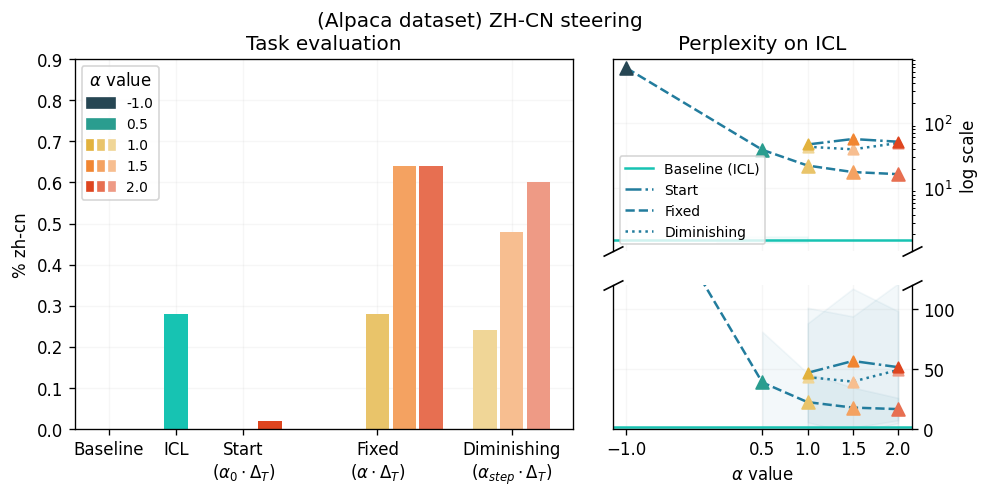

In [139]:
fig = plt.figure(figsize=(9, 4), dpi=120)
spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[5, 3],
                          height_ratios= [4, 3])
ax0 = fig.add_subplot(spec[:, 0])
ax1 = fig.add_subplot(spec[0, 1])
ax2 = fig.add_subplot(spec[1, 1])


width = 0.35
distance = 0.05
ax0.bar(0, avg_language['no_icl'], width, color=palette1[0], label = 'original model (baseline)')
ax0.bar(1, avg_language['icl'], width, color=palette1[1], label = 'icl')

ax0.bar(2 - width - distance, avg_language['editedSTART_1.0'], width, color=palette3_dark[2], label = 'icl')
ax0.bar(2, avg_language['editedSTART_1.5'], width, color=palette3_dark[3], label = 'icl')
ax0.bar(2 + width + distance, avg_language['editedSTART_2.0'], width, color=palette3_dark[4], label = 'icl')

ax0.bar(4 - 2*width - 2*distance, avg_language['edited_-1'], width, color=palette3[0], label = 'icl')
ax0.bar(4 - width - distance, avg_language['edited_0.5'], width, color=palette3[1], label = 'icl')
ax0.bar(4, avg_language['edited_1.0'], width, color=palette3[2], label = 'icl')
ax0.bar(4 + width + distance, avg_language['edited_1.5'], width, color=palette3[3], label = 'icl')
ax0.bar(4 + 2*width + 2*distance, avg_language['edited_2.0'], width, color=palette3[4], label = 'icl')

ax0.bar(6 - width - distance, avg_language['editedDIM_1.0'], width, color=palette3_light[2], label = 'icl')
ax0.bar(6, avg_language['editedDIM_1.5'], width, color=palette3_light[3], label = 'icl')
ax0.bar(6 + width + distance, avg_language['editedDIM_2.0'], width, color=palette3_light[4], label = 'icl')

x0_labels = [
    'Baseline', 'ICL', 
    'Start\n' + r'($ \alpha_{0} \cdot \Delta_T$)',
    'Fixed\n' + r'($ \alpha \cdot \Delta_T$)', 
    'Diminishing\n' + r'($ \alpha_{step} \cdot \Delta_T$)',
]
ax0.set_xticks([0, 1, 2, 4, 6])
ax0.set_xticklabels(x0_labels)
ax0.set_ylim(0, 0.9)

ax0.set_ylabel(f'% {language_to_count}')
ax0.grid(alpha=0.1)
ax0.set_axisbelow(True)
ax0.set_title('Task evaluation')

ppl_baseline = avg_perplexity['icl']
ci_ppl_baseline_upper = ppl_baseline + ci_perplexity['icl']
ci_ppl_baseline_lower = ppl_baseline - ci_perplexity['icl']

amount_of_edit, ppls = [], []
cis_upper, cis_lower = [], []
amount_of_edit_DIM, ppls_DIM = [], []
cis_upper_DIM, cis_lower_DIM = [], []
amount_of_edit_START, ppls_START = [], []
cis_upper_START, cis_lower_START = [], []
for k, avg_ppl in avg_perplexity.items():
    if k != 'icl':      # already collected as baseline
        if 'DIM' in k:
            amount_of_edit_DIM.append(float(k.split('_')[-1]))
            ppls_DIM.append(avg_ppl)
            cis_upper_DIM.append(avg_ppl + ci_perplexity[k])
            cis_lower_DIM.append(avg_ppl - ci_perplexity[k])
        elif 'START' in k:
            amount_of_edit_START.append(float(k.split('_')[-1]))
            ppls_START.append(avg_ppl)
            cis_upper_START.append(avg_ppl + ci_perplexity[k])
            cis_lower_START.append(avg_ppl - ci_perplexity[k])
        else:
            amount_of_edit.append(float(k.split('_')[-1]))  # [-1, 0.5, 1, ...]
            ppls.append(avg_ppl)
            cis_upper.append(avg_ppl + ci_perplexity[k])
            cis_lower.append(avg_ppl - ci_perplexity[k])

# plot perplexity
ax1.axhline(y=ppl_baseline, color=palette1[1], linestyle='-')
ax1.fill_between([0, 1], ci_ppl_baseline_lower, ci_ppl_baseline_upper, color=palette1[1], alpha=.05)
ax2.axhline(y=ppl_baseline, color=palette1[1], linestyle='-')
ax2.fill_between([0, 1], ci_ppl_baseline_lower, ci_ppl_baseline_upper, color=palette1[1], alpha=.05)

# std perplexity
ax1.plot(amount_of_edit, ppls, linestyle='--', color = palette1[0])
fake_first_num = 230       # used per l'inclinazione della linea
ax2.plot(amount_of_edit, [fake_first_num, *ppls[1:]], linestyle='--', color = palette1[0])
ax2.fill_between(amount_of_edit[1:], cis_lower[1:], cis_upper[1:], color=palette1[0], alpha=.05)
# print markers with the different colors
for i, (x, y) in enumerate(zip(amount_of_edit, ppls)):
    ax1.scatter(x, y, marker='^', s=60, color=palette3[i], zorder=3)
    ax2.scatter(x, y, marker='^', s=60, color=palette3[i], zorder=3)

# perplexity DIM
ax1.plot(amount_of_edit_DIM, ppls_DIM, linestyle=':', color = palette1[0])
ax2.plot(amount_of_edit_DIM, ppls_DIM, linestyle=':', color = palette1[0])
ax2.fill_between(amount_of_edit_DIM, cis_lower_DIM, cis_upper_DIM, color=palette1[0], alpha=.05)
for i, (x, y) in enumerate(zip(amount_of_edit_DIM, ppls_DIM)):
    ax1.scatter(x, y, marker='^', s=40, color=palette3_light[i+2], zorder=3)
    ax2.scatter(x, y, marker='^', s=40, color=palette3_light[i+2], zorder=3)

# perplexity START
ax1.plot(amount_of_edit_START, ppls_START, linestyle='-.', color = palette1[0])
ax2.plot(amount_of_edit_START, ppls_START, linestyle='-.', color = palette1[0])
ax2.fill_between(amount_of_edit_START, cis_lower_START, cis_upper_START, color=palette1[0], alpha=.05)
for i, (x, y) in enumerate(zip(amount_of_edit_START, ppls_START)):
    ax1.scatter(x, y, marker='^', s=40, color=palette3_dark[i+2], zorder=3)
    ax2.scatter(x, y, marker='^', s=40, color=palette3_dark[i+2], zorder=3)

ax1.set_xticks(amount_of_edit)
ax2.set_xticks(amount_of_edit)
ax1.grid(alpha=.1)
ax2.grid(alpha=.1)
ax1.set_axisbelow(True)
ax2.set_axisbelow(True)
ax1.yaxis.set_label_position("right")
ax2.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
ax2.yaxis.tick_right()
ax1.set_title('Perplexity on ICL')

# adjustments
ax1.set_yscale('log')
# ax1.ticklabel_format(axis='y', style='sci', scilimits=(1, 3))

ax2.set_ylim(0, 120)  # most of the data
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top() # move on top the ticks and
ax1.tick_params(labeltop=False)  # then don't put tick labels at the top
ax1.tick_params(width=0)    # and set the small ticks to 0 width
ax2.xaxis.tick_bottom()
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(
    marker=[(-1, -d), (1, d)], 
    markersize=12, 
    linestyle="none", 
    color='k', mec='k', mew=1, clip_on=False
)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

ax1.set_ylabel('log scale')
ax2.set_xlabel(r'$\alpha$ value')

# legend(s)
legend_patches = []
for i, edit in enumerate(amount_of_edit):
    if edit > 0.5:
        legend_patches.append([
            mpatches.Patch(color=palette3_dark[i], label=str(edit)),
            mpatches.Patch(color=palette3[i], label=str(edit)),
            mpatches.Patch(color=palette3_light[i], label=str(edit))
        ])
    else:
        legend_patches.append(mpatches.Patch(color=palette3[i], label= str(edit)))
ax0.legend(
    handles=legend_patches, labels=amount_of_edit, 
    loc='upper left', title=r'$\alpha$ value', 
    ncol=1, fontsize='small', handler_map = {list: HandlerTuple(None)}
)
legend_patches = [
    Line2D([0], [0], color=palette1[1], linestyle='-', label='Baseline (ICL)'),
    Line2D([0], [0], color=palette1[0], linestyle='-.', label='Start'),
    Line2D([0], [0], color=palette1[0], linestyle='--', label='Fixed'),
    Line2D([0], [0], color=palette1[0], linestyle=':', label='Diminishing'),
]
ax1.legend(
    handles=legend_patches, loc='lower left',
    ncol=1, fontsize='small', handler_map = {list: HandlerTuple(None)}
)


sup_title = f'(Alpaca dataset) {language_to_count.upper()} steering'
fig.suptitle(sup_title)
fig.subplots_adjust(wspace=0.1)

fig.savefig(f'./media/{sup_title}.pdf', format='pdf')

# ITunsafe (compositionality)

In [5]:
# load compositionality ITunsafe results
ita_res = read_results('./../output/Mistral-7B-Instruct-v0.2/compositionality/ENunsafe/ENunsafe-ITA/all_evaluated_ENunsafe_ITA_tok30.json')

outputs_types = [t for t in ita_res[0]['output']]
# compute accuracy for task
avg_perplexity = {}
ci_perplexity = {}
avg_language = {}
avg_labels = {}
for k in outputs_types:
    if k in ita_res[0]['perplexity']:
        all_perplexity = [ele['perplexity'][k] for ele in ita_res]
        avg_perplexity[k] = np.mean(all_perplexity)
        ci_perplexity[k] = 1.96 * np.std(all_perplexity)/np.sqrt(len(all_perplexity))

    language_to_count = 'it'
    all_languages = [ele['eval_lang'][k] for ele in ita_res]
    avg_language[k] = all_languages.count(language_to_count) / len(all_languages)

    label_to_count = 'unsafe'
    all_labels = [ele['eval_task'][k]['output'] for ele in ita_res]
    avg_labels[k] = all_labels.count(label_to_count) / len(all_labels)      # inutile qui misurare la toxicity

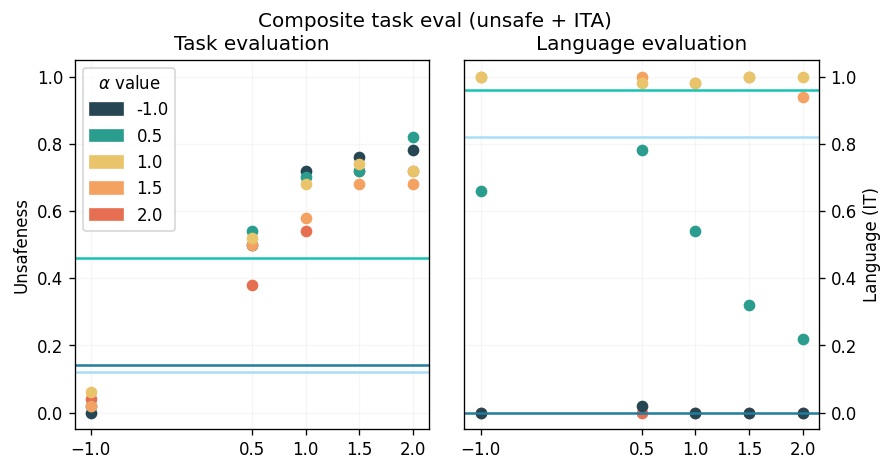

In [78]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 4), dpi=120)

ax0.set_title('Task evaluation')
ax0.set_ylabel('Unsafeness')

ax0.axhline(avg_labels['noicl_ENunsafe'], color=palette1[0], label='noICL baseline')
ax0.axhline(avg_labels['icl_ITunsafe'], color=palette1[1], label='ICL')
ax0.axhline(avg_labels['noicl_ITA'], color=palette1[2], label='noICL + ITA')

only_edited_labels = list(avg_labels.keys())[3:]
first_alphas = [float(ele.split('_')[0]) for ele in only_edited_labels]
first_dataset_name = 'ENunsafe'     # needed to get the second alpha
second_alphas = [float(ele.split('_')[1].replace(f'{first_dataset_name}-', '')) for ele in only_edited_labels]
values = list(avg_labels.values())[3:]
mapping_colors = {alpha: color for alpha, color in zip(set(second_alphas), palette3)}
for x, y, c in zip(first_alphas, values, second_alphas):
    ax0.scatter(x, y, color=mapping_colors[c])

legend_patches = []
for i, edit in enumerate(amount_of_edit):
    legend_patches.append(mpatches.Patch(color=palette3[i], label=str(edit)))
ax0.legend(handles=legend_patches, loc='upper left', title=r'$\alpha$ value')

ax1.set_title('Language evaluation')
ax1.set_ylabel('Language (IT)')

ax1.axhline(avg_language['noicl_ENunsafe'], color=palette1[0], label='noICL baseline')
ax1.axhline(avg_language['icl_ITunsafe'], color=palette1[1], label='ICL')
ax1.axhline(avg_language['noicl_ITA'], color=palette1[2], label='noICL + ITA')

values = list(avg_language.values())[3:]
for x, y, c in zip(first_alphas, values, second_alphas):
    ax1.scatter(x, y, color=mapping_colors[c])

ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()


ax0.set_xticks(np.unique(first_alphas))
ax0.grid(alpha=.1)
ax0.set_axisbelow(True)
ax0.set_ylim(-0.05, 1.05)
ax1.set_xticks(np.unique(first_alphas))
ax1.grid(alpha=.1)
ax1.set_axisbelow(True)
ax1.set_ylim(-0.05, 1.05)


sup_title = 'Composite task eval (unsafe + ITA)'
fig.suptitle(sup_title)
fig.subplots_adjust(wspace=0.1)

fig.savefig(f'./media/{sup_title}.pdf', format='pdf')

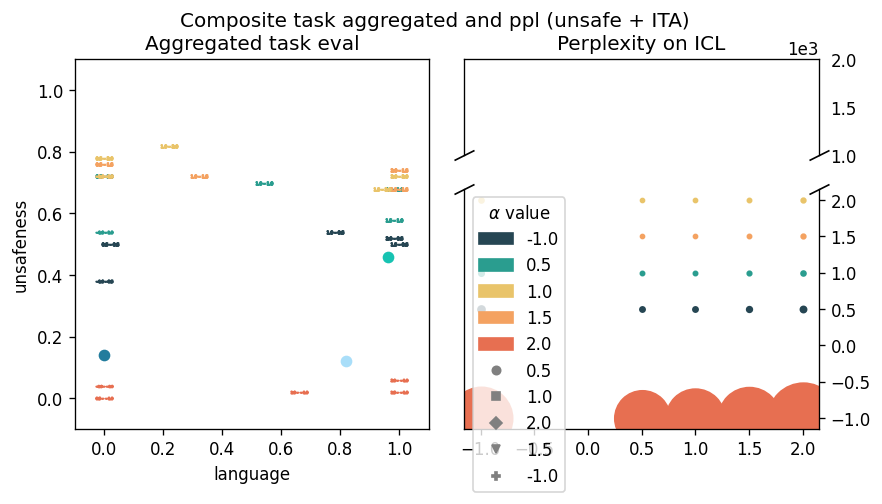

In [90]:
fig = plt.figure(figsize=(8, 4), dpi=120)
spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[1, 1], height_ratios=[2, 5])
ax0 = fig.add_subplot(spec[:, 0])
ax1 = fig.add_subplot(spec[0, 1])
ax2 = fig.add_subplot(spec[1, 1])

ax0.set_title('Aggregated task eval')
ax0.set_ylabel('unsafeness')
ax0.set_xlabel('language')

ax0.scatter(avg_language['noicl_ENunsafe'], avg_labels['noicl_ENunsafe'], color=palette1[0], label='noICL baseline')
ax0.scatter(avg_language['icl_ITunsafe'], avg_labels['icl_ITunsafe'], color=palette1[1], label='ICL')
ax0.scatter(avg_language['noicl_ITA'], avg_labels['noicl_ITA'], color=palette1[2], label='noICL + ITA')

values_language = list(avg_language.values())[3:]
values_labels = list(avg_labels.values())[3:]
mapping_colors = {alpha: color for alpha, color in zip(set(second_alphas), palette3)}
markers = ['o', 's', 'D', 'v', 'P']
mapping_markers = {alpha: marker for alpha, marker in zip(set(second_alphas), markers)}
for x, y, c, m in zip(values_language, values_labels, first_alphas, second_alphas):
    ax0.scatter(x, y, color=mapping_colors[c], marker=rf"${str(m)}-{str(c)}$", s=100)# mapping_markers[m])

ax0.set_ylim(-0.1, 1.1)
ax0.set_xlim(-0.1, 1.1)

ax1.set_title('Perplexity on ICL')


ppls = [ppl for ppl in avg_perplexity.values()]
# ax1.plot(first_alphas, ppls, linestyle='--', color = palette1[0])
# ax2.plot(first_alphas, ppls, linestyle='--', color = palette1[0])
# for x, y, c in zip(first_alphas, ppls, second_alphas):
#     ax1.scatter(x, y, color=mapping_colors[c])
#     ax2.scatter(x, y, color=mapping_colors[c])

for a, b, c in zip(first_alphas, second_alphas, ppls):
    ax2.scatter(a, b, color = mapping_colors[b], s = c)


ax1.yaxis.set_label_position("right")
ax2.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
ax2.yaxis.tick_right()
ax1.set_ylim(1000, 2000)  # outliers only (339424)
ax1.ticklabel_format(axis='y', style='sci', scilimits=(3, 1))
# ax2.set_ylim(0, 24)  # most of the data
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top() # move on top the ticks and
ax1.tick_params(labeltop=False)  # then don't put tick labels at the top
ax1.tick_params(width=0)    # and set the small ticks to 0 width
ax2.xaxis.tick_bottom()

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(
    marker=[(-1, -d), (1, d)], 
    markersize=12, 
    linestyle="none", 
    color='k', mec='k', mew=1, clip_on=False
)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)


legend_patches = []
for i, edit in enumerate(np.unique(first_alphas)):
    legend_patches.append(mpatches.Patch(color=palette3[i], label=str(edit)))
ax2.legend(handles=legend_patches, loc='upper left', title=r'$\alpha$ value')

import matplotlib.lines as mlines
legend_patches2 = []
for alpha, marker in mapping_markers.items():
    legend_patches.append(
        mlines.Line2D([], [], color='gray', marker=marker, linestyle='None', markersize=5, label=alpha)
    )
ax2.legend(handles=legend_patches, loc='upper left', title=r'$\alpha$ value')


sup_title = 'Composite task aggregated and ppl (unsafe + ITA)'
fig.suptitle(sup_title)
fig.subplots_adjust(wspace=0.1)

fig.savefig(f'./media/{sup_title}.pdf', format='pdf')

---

# Compositionality Italian - Toxicity

In [57]:
task_names = []

def get_accuracies_from_dict(dict_results, label_of_interest):
    final_dict = {}
    for approach, values in dict_results.items():
        final_dict[approach] = values.count(label_of_interest) / len(values)

    return final_dict

# safe + Italian on safe dataset
model_name = 'Mistral-7B-Instruct-v0.2'
dataset_name = 'unsafe-BeaverTails'
task1 = 'ITtruthful'
task2 = 'safe-BeaverTails'
tok = 30
language_results = read_results(f'./../output/{model_name}/compositionality/{dataset_name}/{task1}-{task2}/evaluated_{task1}_{task2}_tok{tok}.json')
toxicity_results = read_results(f'./../output/{model_name}/compositionality/{dataset_name}/{task1}-{task2}/evaluated_{task1}_{task2}_tok{tok}_translated.json')
language_results = clean_results(language_results)
toxicity_results = clean_results(toxicity_results)
task_names.append('safe')

accuracies_safesteer_toxicity = get_accuracies_from_dict(toxicity_results, "safe")
accuracies_safesteer_language = get_accuracies_from_dict(language_results, "it")


# unsafe + Italian on safe dataset
model_name = 'Mistral-7B-Instruct-v0.2'
dataset_name = 'unsafe-BeaverTails'
task1 = 'ITtruthful'
task2 = 'unsafe-BeaverTails'
tok = 30
language_results = read_results(f'./../output/{model_name}/compositionality/{dataset_name}/{task1}-{task2}/evaluated_{task1}_{task2}_tok{tok}.json')
toxicity_results = read_results(f'./../output/{model_name}/compositionality/{dataset_name}/{task1}-{task2}/evaluated_{task1}_{task2}_tok{tok}_translated.json')
language_results = clean_results(language_results)
toxicity_results = clean_results(toxicity_results)
task_names.append('unsafe')
accuracies_unsafesteer_toxicity = get_accuracies_from_dict(toxicity_results, "unsafe")
accuracies_unsafesteer_language = get_accuracies_from_dict(language_results, "it")

NameError: name 'read_results' is not defined

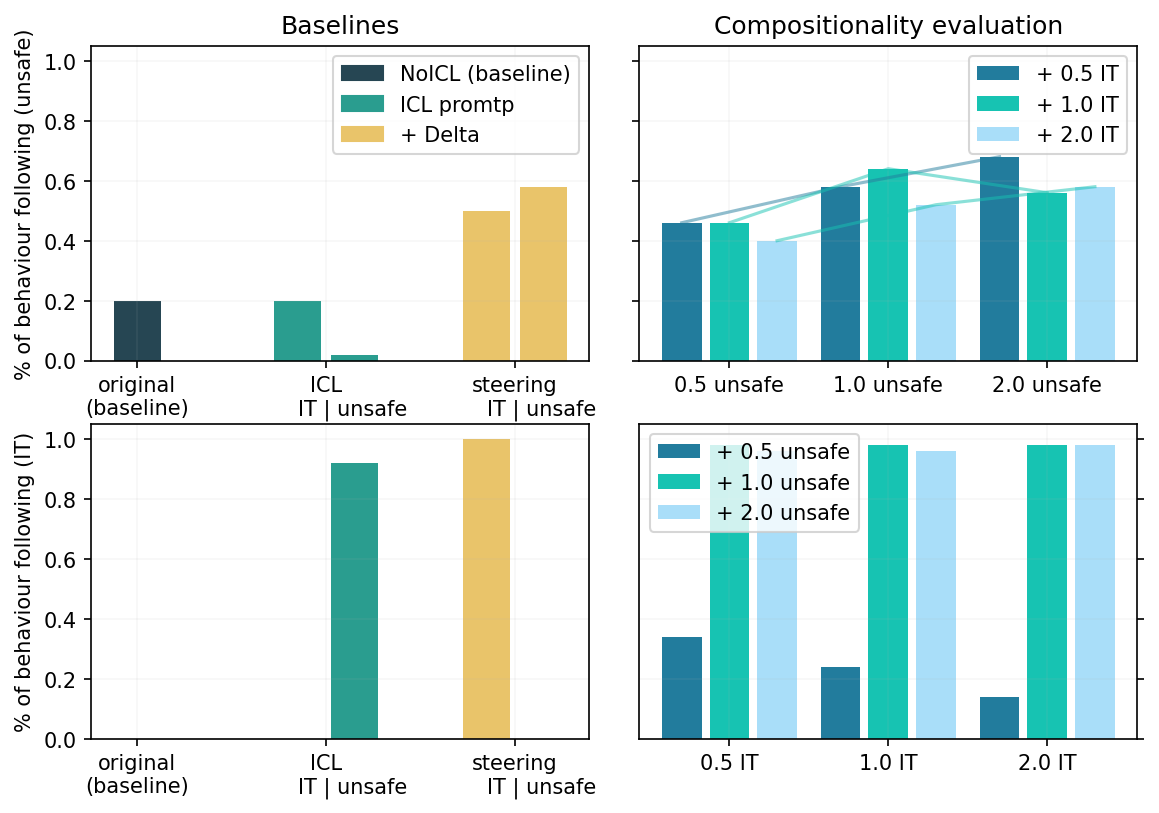

In [18]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(
    2, 2, 
    figsize=(9, 6), dpi=150,
    # gridspec_kw={'width_ratios': [5, 1]}, 
    sharey=True
)

X_axis = np.arange(len(accuracies_unsafesteer_toxicity))

width = 0.25
space = 0.05

ax0.set_title('Baselines')
ax0.grid(alpha = .1)
# ax0.spines['right'].set_visible(False)
ax0.bar(0, accuracies_unsafesteer_toxicity['no_icl'], width, label='original (baseline)', color=palette1[0])

ax0.bar(1 - width / 2 - space / 2, accuracies_unsafesteer_toxicity['icl_ITtruthful'], width, label='ICL IT', color=palette1[1])
ax0.bar(1 + width / 2 + space / 2, accuracies_unsafesteer_toxicity['icl_unsafe-BeaverTails'], width, label='ICL unsafe', color=palette1[1])

ax0.bar(2 - width / 2 - space / 2, accuracies_unsafesteer_toxicity['ITtruthful'], width, label='IT steering', color=palette1[2])
ax0.bar(2 + width / 2 + space / 2, accuracies_unsafesteer_toxicity['unsafe-BeaverTails'], width, label='unsafe steering', color=palette1[2])
legend_patches = []
legend_patches.append(mpatches.Patch(color=palette1[0], label='NoICL (baseline)'))
legend_patches.append(mpatches.Patch(color=palette1[1], label='ICL promtp'))
legend_patches.append(mpatches.Patch(color=palette1[2], label='+ Delta'))
ax0.legend(handles=legend_patches, loc='upper center')

ax0.set_ylabel('% of behaviour following (unsafe)')
ax0.set_xticks(
    [0, 1, 2], 
    labels=['original\n(baseline)', 'ICL\n        IT | unsafe', 'steering\n        IT | unsafe'],
)

ax1.set_title('Compositionality evaluation')
ax1.grid(alpha=0.1)
# ax1.spines['left'].set_visible(False)
# ax1.yaxis.tick_right()
ax1.bar(0 - width - space, accuracies_unsafesteer_toxicity['0.5_ITtruthful-0.5_unsafe-BeaverTails'], width, label='0.5 x IT, 0.5', color=palette2[0])
ax1.bar(0, accuracies_unsafesteer_toxicity['1.0_ITtruthful-0.5_unsafe-BeaverTails'], width, label='0.5 x IT, 1.0', color=palette2[1])
ax1.bar(0 + width + space, accuracies_unsafesteer_toxicity['2.0_ITtruthful-0.5_unsafe-BeaverTails'], width, label='0.5 x IT, 2.0', color=palette2[2])

ax1.bar(1 - width - space, accuracies_unsafesteer_toxicity['0.5_ITtruthful-1.0_unsafe-BeaverTails'], width, label='1.0 x IT, 0.5', color=palette2[0])
ax1.bar(1, accuracies_unsafesteer_toxicity['1.0_ITtruthful-1.0_unsafe-BeaverTails'], width, label='1.0 x IT, 1.0', color=palette2[1])
ax1.bar(1 + width + space, accuracies_unsafesteer_toxicity['2.0_ITtruthful-1.0_unsafe-BeaverTails'], width, label='1.0 x IT, 2.0', color=palette2[2])

ax1.bar(2 - width - space, accuracies_unsafesteer_toxicity['0.5_ITtruthful-2.0_unsafe-BeaverTails'], width, label='2.0 x IT, 0.5', color=palette2[0])
ax1.bar(2, accuracies_unsafesteer_toxicity['1.0_ITtruthful-2.0_unsafe-BeaverTails'], width, label='2.0 x IT, 1.0', color=palette2[1])
ax1.bar(2 + width + space, accuracies_unsafesteer_toxicity['2.0_ITtruthful-2.0_unsafe-BeaverTails'], width, label='2.0 x IT, 2.0', color=palette2[2])

ax1.plot(
    [0 - width - space, 1 - width - space, 2 - width - space], 
    [
        accuracies_unsafesteer_toxicity['0.5_ITtruthful-0.5_unsafe-BeaverTails'], 
        accuracies_unsafesteer_toxicity['0.5_ITtruthful-1.0_unsafe-BeaverTails'], 
        accuracies_unsafesteer_toxicity['0.5_ITtruthful-2.0_unsafe-BeaverTails'], 
    ],
    width, label='0.5 x IT, 0.5', color=palette2[0], alpha = .5
)
ax1.plot(
    [0, 1, 2], 
    [
        accuracies_unsafesteer_toxicity['1.0_ITtruthful-0.5_unsafe-BeaverTails'], 
        accuracies_unsafesteer_toxicity['1.0_ITtruthful-1.0_unsafe-BeaverTails'], 
        accuracies_unsafesteer_toxicity['1.0_ITtruthful-2.0_unsafe-BeaverTails'], 
    ],
    width, label='0.5 x IT, 0.5', color=palette2[1], alpha = .5
)
ax1.plot(
    [0 + width + space, 1 + width + space, 2 + width + space], 
    [
        accuracies_unsafesteer_toxicity['2.0_ITtruthful-0.5_unsafe-BeaverTails'], 
        accuracies_unsafesteer_toxicity['2.0_ITtruthful-1.0_unsafe-BeaverTails'], 
        accuracies_unsafesteer_toxicity['2.0_ITtruthful-2.0_unsafe-BeaverTails'], 
    ],
    width, label='0.5 x IT, 0.5', color=palette2[1], alpha = .5
)


legend_patches = []
legend_patches.append(mpatches.Patch(facecolor=palette2[0], label='+ 0.5 IT'))
legend_patches.append(mpatches.Patch(facecolor=palette2[1], label='+ 1.0 IT'))
legend_patches.append(mpatches.Patch(facecolor=palette2[2], label='+ 2.0 IT'))
ax1.legend(handles=legend_patches)
ax1.set_xticks(
    [0, 1, 2], 
    labels=['0.5 unsafe', '1.0 unsafe', '2.0 unsafe'],
)

ax2.grid(alpha = .1)
# ax2.spines['right'].set_visible(False)
ax2.bar(0, accuracies_unsafesteer_language['no_icl'], width, label='original (baseline)', color=palette1[0])

ax2.bar(1 - width / 2 - space / 2, accuracies_unsafesteer_language['icl_ITtruthful'], width, label='ICL IT', color=palette1[1])
ax2.bar(1 + width / 2 + space / 2, accuracies_unsafesteer_language['icl_unsafe-BeaverTails'], width, label='ICL unsafe', color=palette1[1])

ax2.bar(2 - width / 2 - space / 2, accuracies_unsafesteer_language['ITtruthful'], width, label='IT steering', color=palette1[2])
ax2.bar(2 + width / 2 + space / 2, accuracies_unsafesteer_language['unsafe-BeaverTails'], width, label='unsafe steering', color=palette1[2])
ax2.set_ylabel('% of behaviour following (IT)')
ax2.set_xticks(
    [0, 1, 2], 
    labels=['original\n(baseline)', 'ICL\n        IT | unsafe', 'steering\n        IT | unsafe'],
)

ax3.grid(alpha=0.1)
# ax3.spines['left'].set_visible(False)
ax3.yaxis.tick_right()
ax3.bar(0 - width - space, accuracies_unsafesteer_language['0.5_ITtruthful-0.5_unsafe-BeaverTails'], width, label='0.5 x IT, 0.5', color=palette2[0], alpha = 1)
ax3.bar(0, accuracies_unsafesteer_language['1.0_ITtruthful-0.5_unsafe-BeaverTails'], width, label='0.5 x IT, 1.0', color=palette2[1])
ax3.bar(0 + width + space, accuracies_unsafesteer_language['2.0_ITtruthful-0.5_unsafe-BeaverTails'], width, label='0.5 x IT, 2.0', color=palette2[2])

ax3.bar(1 - width - space, accuracies_unsafesteer_language['0.5_ITtruthful-1.0_unsafe-BeaverTails'], width, label='1.0 x IT, 0.5', color=palette2[0], alpha = 1)
ax3.bar(1, accuracies_unsafesteer_language['1.0_ITtruthful-1.0_unsafe-BeaverTails'], width, label='1.0 x IT, 1.0', color=palette2[1])
ax3.bar(1 + width + space, accuracies_unsafesteer_language['2.0_ITtruthful-1.0_unsafe-BeaverTails'], width, label='1.0 x IT, 2.0', color=palette2[2])

ax3.bar(2 - width - space, accuracies_unsafesteer_language['0.5_ITtruthful-2.0_unsafe-BeaverTails'], width, label='2.0 x IT, 0.5', color=palette2[0], alpha = 1)
ax3.bar(2, accuracies_unsafesteer_language['1.0_ITtruthful-2.0_unsafe-BeaverTails'], width, label='2.0 x IT, 1.0', color=palette2[1])
ax3.bar(2 + width + space, accuracies_unsafesteer_language['2.0_ITtruthful-2.0_unsafe-BeaverTails'], width, label='2.0 x IT, 2.0', color=palette2[2])

ax3.set_xticks(
    [0, 1, 2], 
    labels=['0.5 IT', '1.0 IT', '2.0 IT'],
)

legend_patches = []
legend_patches.append(mpatches.Patch(facecolor=palette2[0], label='+ 0.5 unsafe'))
legend_patches.append(mpatches.Patch(facecolor=palette2[1], label='+ 1.0 unsafe'))
legend_patches.append(mpatches.Patch(facecolor=palette2[2], label='+ 2.0 unsafe'))
ax3.legend(handles=legend_patches)


legend_patches = []
legend_patches.append(mpatches.Patch(color=palette1[0], label='NoICL (baseline)'))
legend_patches.append(mpatches.Patch(color=palette1[1], label='ICL promtp'))
legend_patches.append(mpatches.Patch(color=palette1[2], label='+ Delta'))
ax0.legend(handles=legend_patches)

fig.subplots_adjust(wspace=0.1)

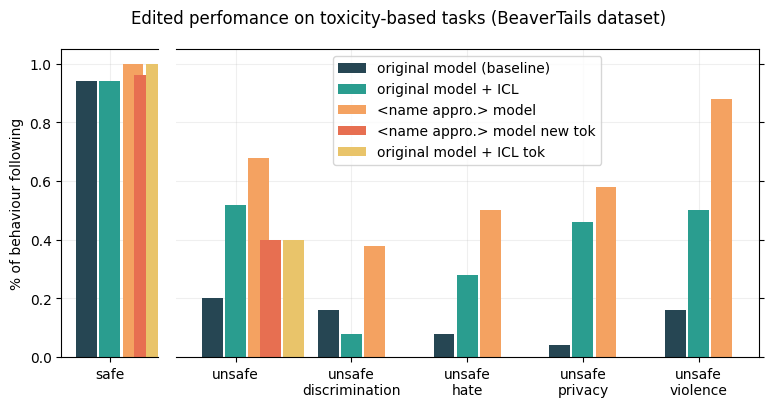

In [17]:
# actual plot
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(9, 4), dpi=100, gridspec_kw={'width_ratios': [1, 6]}, sharey=True)

width = 0.18
ax0.bar(0 - 0.2, original_accuracies[0], width, color=palette1[0], label = 'original model (baseline)')
ax0.bar(0, icl_accuracies[0], width, color=palette1[1], label = 'original model + ICL')
ax0.bar(0 + 0.2, edited_accuracies[0], width, color=palette1[3], label = '<name appro.> model')
ax0.bar(0 + 0.3, new_edited_accuracies[0], width, color=palette1[4], label='<name appro.> model new tok')
ax0.bar(0 + 0.4, new_icl_accuracies[0], width, color=palette1[2], label='original model + ICL tok')
ax0.set_xticks([0], [task_names[0]])

X_axis = np.arange(len(task_names) - 1)
ax1.bar(X_axis - 0.2, original_accuracies[1:], width, color=palette1[0], label = 'original model (baseline)')
ax1.bar(X_axis, icl_accuracies[1:], width, color=palette1[1], label = 'original model + ICL')
ax1.bar(X_axis + 0.2, edited_accuracies[1:], width, color=palette1[3], label = '<name appro.> model')
ax1.bar(0 + 0.3, new_edited_accuracies[1], width, color=palette1[4], label='<name appro.> model new tok')
ax1.bar(0 + 0.5, new_icl_accuracies[1], width, color=palette1[2], label='original model + ICL tok')

ax1.set_xticks(X_axis, task_names[1: ])
# ax1.set_xlabel("Unsafe Task")
ax0.set_ylabel("% of behaviour following")
fig.suptitle("Edited perfomance on toxicity-based tasks (BeaverTails dataset)")
ax1.legend(loc='upper center')

ax0.set_axisbelow(True)
ax1.set_axisbelow(True)

ax0.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.yaxis.tick_right()
# ax1.yaxis.set_visible(False)
ax0.grid(alpha = .2)
ax1.grid(alpha = .2)

factor = 2.1
ax0.set_xlim(-0.2 * factor, 0.2 * factor)
fig.subplots_adjust(wspace=0.05)

fig.savefig('./media/toxicity_beavertailsg.pdf', format='pdf')

# Single plot for matrix

/var/folders/jt/wnltq_1x0bs7s0y9wz6klhmm0000gn/T/ipykernel_47988/1154099262.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


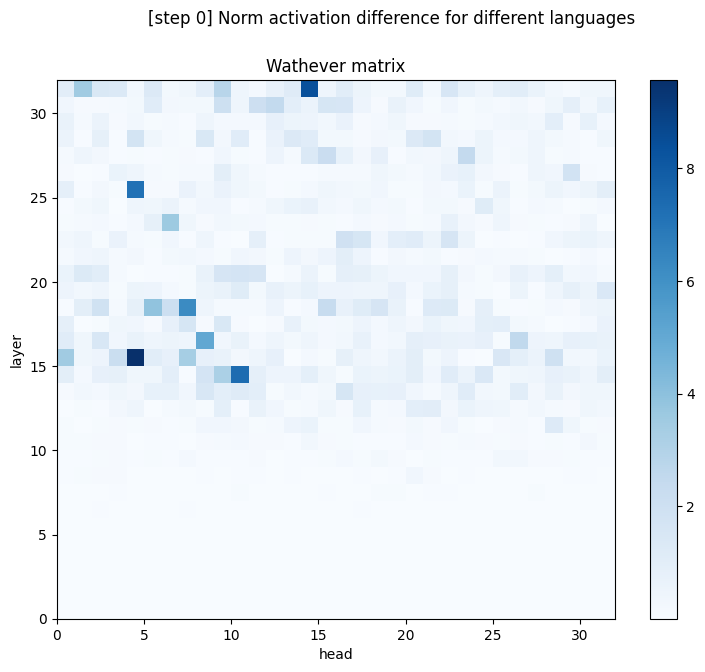

In [56]:
matrix = torch.load('./../output/Mistral-7B-Instruct-v0.2/ENi2f/diff/diff_mean_act_icl4_tok30_ENi2f-ENf2i.pt')
# matrix = torch.load('./../output/Mistral-7B-Instruct-v0.2/ENi2f/diff/mean_activations_A_icl4_tok30_ENi2f.pt')
# matrix = torch.load('./../output/Mistral-7B-Instruct-v0.2/ENi2f/diff/mean_activations_B_icl4_tok30_ENf2i.pt')

from matplotlib import cm, colors
fig, ax = plt.subplots(figsize=(9, 7), dpi=100)

# parameters
aggregation_fun = torch.norm
gen_step = 0

cmap = cm.Blues if aggregation_fun == torch.norm else cm.BrBG

# vmin = -0.2  # Define your minimum value
# vmax = 0.2   # Define your maximum value

ax.set_title('Wathever matrix')
ax.set_xlabel('head')
ax.set_ylabel('layer')
to_plot = aggregation_fun(matrix[gen_step], dim=-1)
pc = ax.pcolormesh(
    to_plot, 
    norm=colors.CenteredNorm() if aggregation_fun == torch.mean else None,
    cmap=cmap,
)
fig.colorbar(pc, ax=ax)

fig.suptitle(f"[step {gen_step}] {'Norm' if aggregation_fun == torch.norm else 'Mean'} activation difference for different languages ")
fig.show()

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# Language activations

In [2]:
import torch

In [3]:
ita = torch.load('./../output/Mistral-7B-Instruct-v0.2/ITA/diff/diff_mean_act_icl4_tok30_ITA-ENG.pt')
fra = torch.load('./../output/Mistral-7B-Instruct-v0.2/FRA/diff/diff_mean_act_icl4_tok30_FRA-ENG.pt')
spa = torch.load('./../output/Mistral-7B-Instruct-v0.2/SPA/diff/diff_mean_act_icl4_tok30_SPA-ENG.pt')
zho = torch.load('./../output/Mistral-7B-Instruct-v0.2/ZHO/diff/diff_mean_act_icl4_tok30_ZHO-ENG.pt')

languages = ['ita', 'fra', 'spa', 'zho']

Text(0.5, 0.98, '[step 0] Norm activation difference for different languages ')

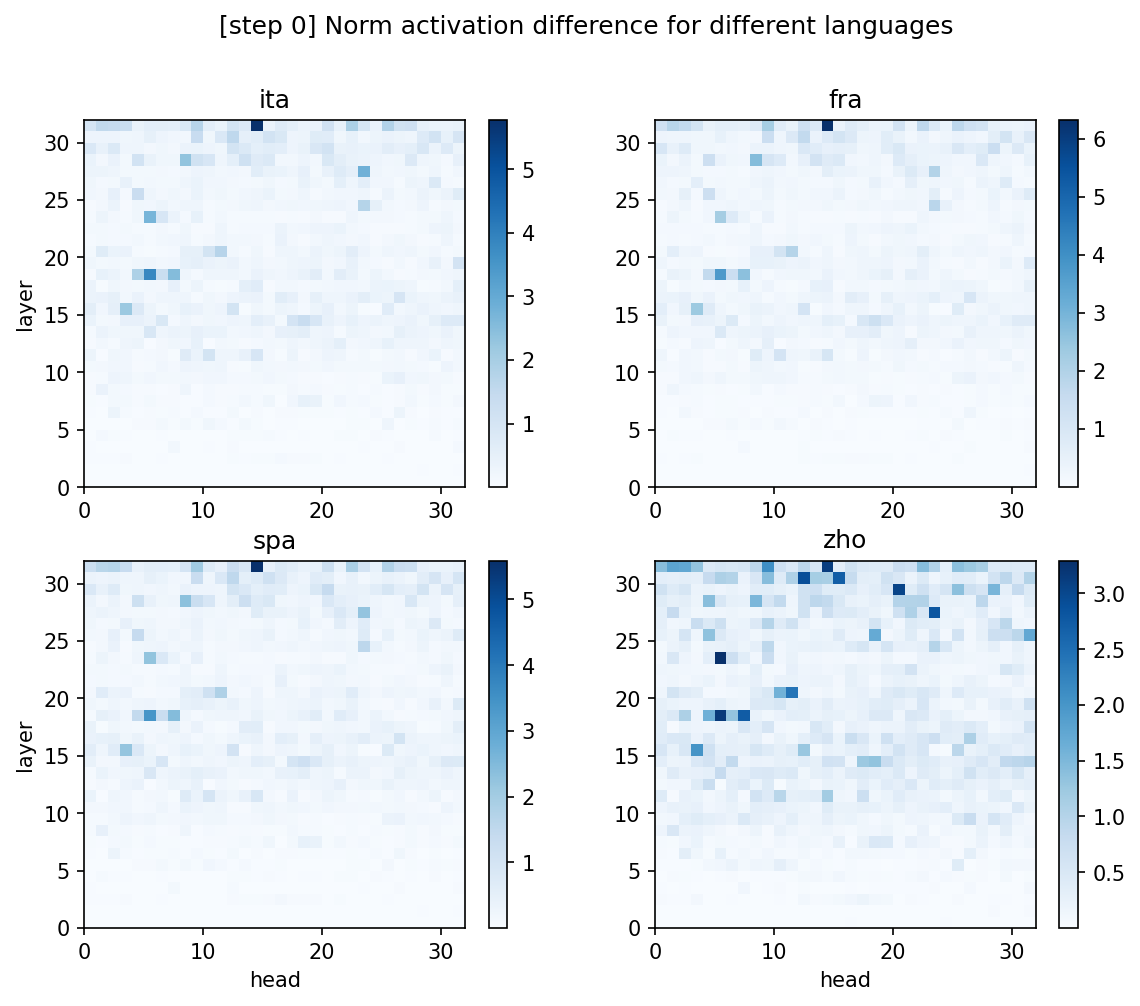

In [54]:
from matplotlib import cm, colors
n_cols = 2
fig, axs = plt.subplots(2, n_cols, figsize=(9, 7), dpi=150)

# parameters
aggregation_fun = torch.norm
gen_step = 0

ax_flatten = [axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1]]

cmap = cm.Blues if aggregation_fun == torch.norm else cm.BrBG

# vmin = -0.2  # Define your minimum value
# vmax = 0.2   # Define your maximum value

for i, (ax, head_matrix) in enumerate(zip(ax_flatten, [ita, fra, spa, zho])):
    ax.set_title(languages[i])
    if not i < len(ax_flatten) - 2:
        ax.set_xlabel('head')
    if i % n_cols == 0:
        ax.set_ylabel('layer')
    to_plot = aggregation_fun(head_matrix[gen_step], dim=-1)
    pc = ax.pcolormesh(
        to_plot, 
        norm=colors.CenteredNorm() if aggregation_fun == torch.mean else None,
        cmap=cmap,
    )
    fig.colorbar(pc, ax=ax)

fig.suptitle(f"[step {gen_step}] {'Norm' if aggregation_fun == torch.norm else 'Mean'} activation difference for different languages ")

/var/folders/jt/wnltq_1x0bs7s0y9wz6klhmm0000gn/T/ipykernel_47988/2096941694.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


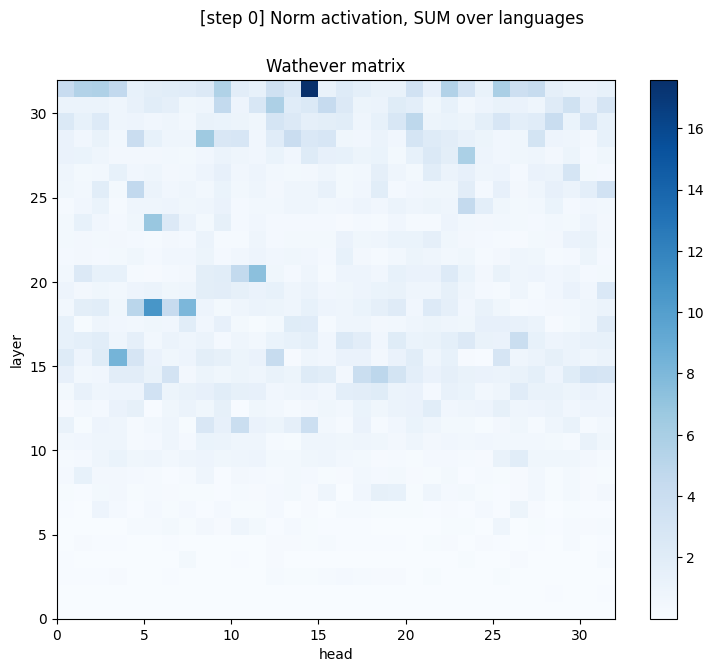

In [55]:
fig, ax = plt.subplots(figsize=(9, 7), dpi=100)

# parameters
aggregation_fun = torch.norm
gen_step = 0

cmap = cm.Blues if aggregation_fun == torch.norm else cm.BrBG

# vmin = -0.2  # Define your minimum value
# vmax = 0.2   # Define your maximum value

ax.set_title('Wathever matrix')
ax.set_xlabel('head')
ax.set_ylabel('layer')

to_plot = aggregation_fun(ita + fra + spa + zho, dim=-1)
to_plot = to_plot[gen_step]

pc = ax.pcolormesh(
    to_plot, 
    norm=colors.CenteredNorm() if aggregation_fun == torch.mean else None,
    cmap=cmap,
)
fig.colorbar(pc, ax=ax)

fig.suptitle(f"[step {gen_step}] {'Norm' if aggregation_fun == torch.norm else 'Mean'} activation, SUM over languages ")
fig.show()

/var/folders/jt/wnltq_1x0bs7s0y9wz6klhmm0000gn/T/ipykernel_47988/1029669577.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


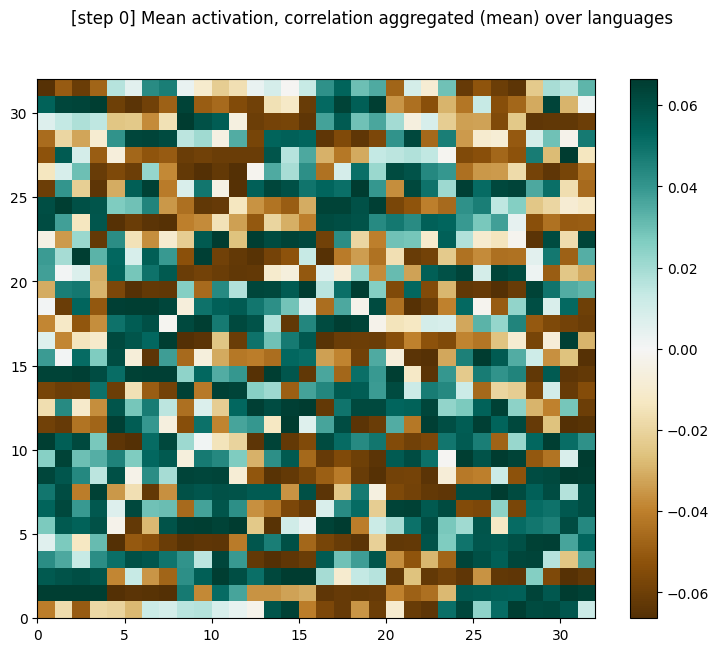

In [53]:
aggregation_fun = torch.mean
gen_step = 0

# correlation between ita and fra, ita and spa, ita and zho
flatten_ita = aggregation_fun(ita, dim=-1)[gen_step].flatten()
flatten_fra = aggregation_fun(fra, dim=-1)[gen_step].flatten()
flatten_spa = aggregation_fun(spa, dim=-1)[gen_step].flatten()
flatten_zho = aggregation_fun(zho, dim=-1)[gen_step].flatten()

correlation = np.corrcoef(torch.vstack([flatten_ita, flatten_fra, flatten_spa, flatten_zho]), rowvar=False)
to_plot = correlation.mean(-1).reshape(32, 32)


fig, ax = plt.subplots(figsize=(9, 7), dpi=100)
pc = ax.pcolormesh(
    to_plot, 
    norm=colors.CenteredNorm() if aggregation_fun == torch.mean else None,
    cmap=cmap,
)
fig.colorbar(pc, ax=ax)

fig.suptitle(f"[step {gen_step}] {'Norm' if aggregation_fun == torch.norm else 'Mean'} activation, correlation aggregated (mean) over languages ")
fig.show()

# Perplexity -head selection

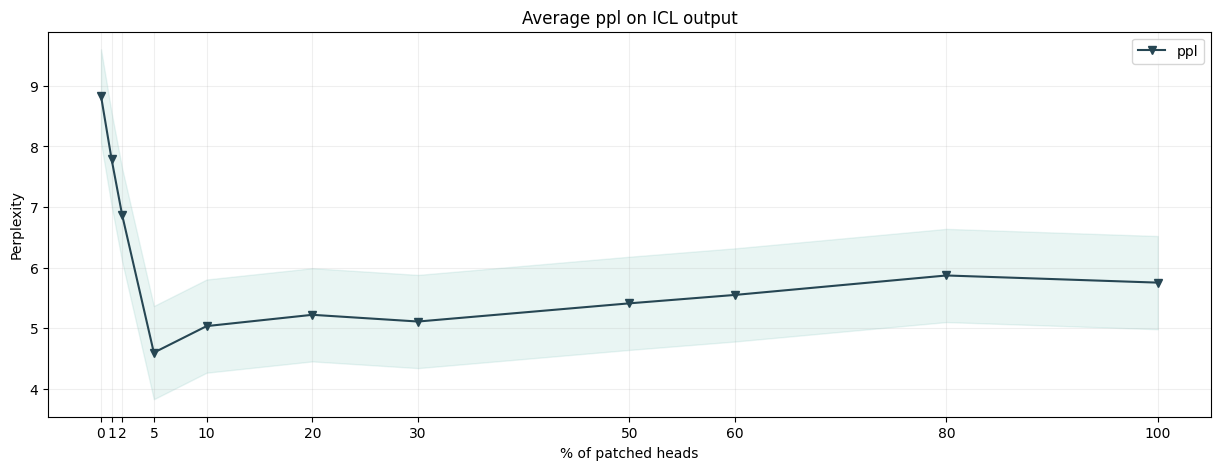

In [369]:
model_name = 'stablelm-2-zephyr-1_6b'
dataset_name = 'ITtruthful'
with open(f'./../output/{model_name}/{dataset_name}/diff/top_heads_results_{dataset_name}_ICL_ppl.json') as f:
    top_heads_res = json.load(f)

perplexities = []
for res in top_heads_res:
    perplexities.append(
        torch.tensor(res['perplexities'])
    )
ppls = torch.stack(perplexities).mean(dim=0)

fig, ax = plt.subplots(figsize=(15, 5), dpi=100)
y = ppls
x = top_heads_res[0]['percs']
ci = 1.96 * y.std()/np.sqrt(len(x))

ax.plot(top_heads_res[0]['percs'], ppls, color = palette1[0], label = 'ppl', marker='v')
ax.fill_between(x, (y-ci), (y+ci), alpha=.1, color = palette1[1])
ax.set_title('Average ppl on ICL output')
ax.set_xticks(x, labels=[f'{i*100:.0f}' for i in x], rotation = 0)
ax.set_xlabel('% of patched heads')
ax.set_ylabel('Perplexity')
ax.legend()
ax.grid(alpha = .2)

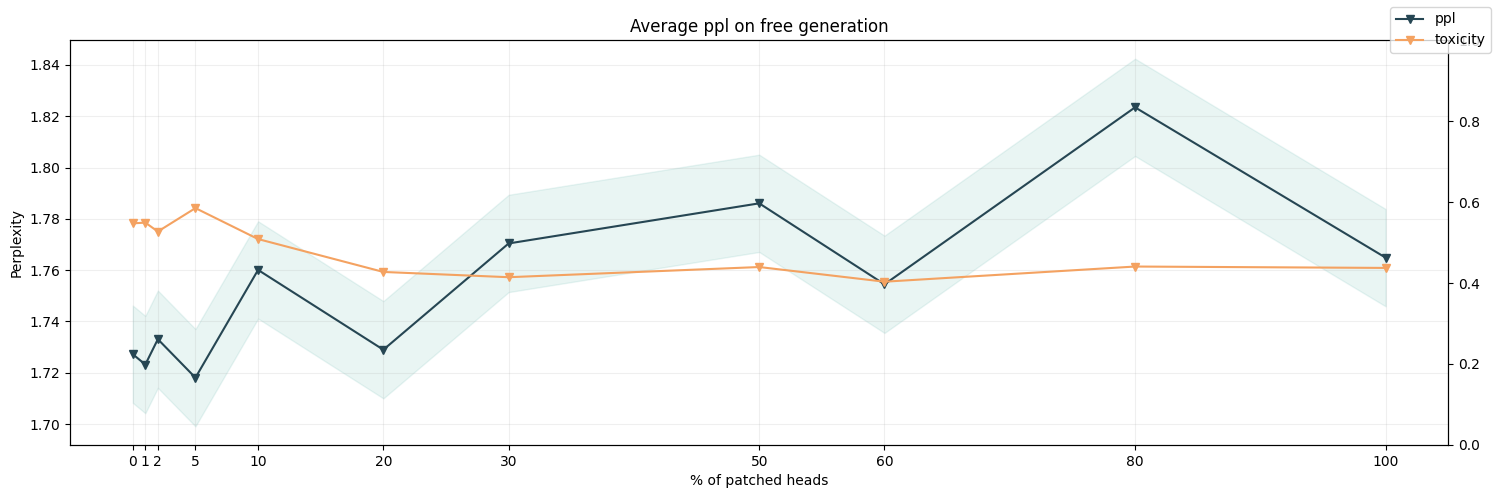

In [370]:
model_name = 'stablelm-2-zephyr-1_6b'
dataset_name = 'unsafe-BeaverTails'
with open(f'./../output/{model_name}/{dataset_name}/diff/top_heads_results_{dataset_name}.json') as f:
    top_heads_res = json.load(f)

perplexities = []
eval_scores = []
for res in top_heads_res:
    perplexities.append(
        torch.tensor(res['perplexities'])
    )
    eval_scores.append(
        torch.tensor(res['eval_labels'])
    )
ppls = torch.stack(perplexities).mean(dim=0)
scores = torch.stack(eval_scores).mean(dim=0)


fig, ax = plt.subplots(figsize=(15, 5), dpi=100)
y = ppls
x = top_heads_res[0]['percs']
ci = 1.96 * y.std()/np.sqrt(len(x))

ax.plot(x, ppls, color = palette1[0], label = 'ppl', marker='v')
ax2 = ax.twinx()
ax2.plot(x, scores, color = palette1[3], label = 'toxicity', marker='v')
ax2.set_ylim([0, 1])
ax.fill_between(x, (y-ci), (y+ci), alpha=.1, color = palette1[1])
ax.set_title('Average ppl on free generation')
ax.set_xticks(x, labels=[f'{i*100:.0f}' for i in x], rotation = 0)
ax.set_xlabel('% of patched heads')
ax.set_ylabel('Perplexity')
fig.legend()
fig.tight_layout()  # otherwise the right y-label is slightly clipped

ax.grid(alpha = .2)

# Random


## Mgsm noicl vs icl FRA vs icl

In [23]:
import json
with open('./../output/Mistral-7B-Instruct-v0.2/FRmgsm/diff/icl4_tok200.json') as f:
    results = json.load(f)
print(len(results))

no_icl_correct = 0
icl_FRA_correct = 0
icl_ENG_correct = 0

for res in results:
    gold = res['gold']
    if gold in res['output']['no_icl']:
        no_icl_correct += 1
    if gold in res['output']['icl']:
        icl_FRA_correct += 1
    if gold in res['output']['icl_original']:
        icl_ENG_correct += 1

69


In [24]:
print(f'Accuracy no_icl: {no_icl_correct / len(results) * 100}')
print(f'Accuracy icl_FRA: {icl_FRA_correct / len(results) * 100}')
print(f'Accuracy icl_ENG: {icl_ENG_correct / len(results) * 100}')

Accuracy no_icl: 34.78260869565217
Accuracy icl_FRA: 34.78260869565217
Accuracy icl_ENG: 34.78260869565217


In [16]:
results[0]

{'prompt': "Q: Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market? \nA:",
 'gold': '18',
 'output': {'icl': 'Respuesta paso a paso: Janet pone 16 huevos de oca por día. Come tres para el desayuno y hace muffins para sus amigos con cuatro huevos de oca cada día. Vende el resto en el mercado agrícola por 2 dólares por huevo de oca fresco. Por lo tanto, vende 16 - 3 - 4 = 9 huevos de oca frescos por día. Y por cada huevo de oca fresco vende 2 dólares, por lo tanto, vende 9 * 2 = 18 dólares por día. La respuesta es 18 dólares.',
  'no_icl': "Janet uses 3 eggs for breakfast and 4 eggs for baking muffins, so she sells 16 - 3 - 4 = <<16-3-4=11>>11 eggs per day at the farmers' market. At $2 per egg, she makes 11 * $2 = $<<11*2=22>>22 per day.",
  'icl_original': 'Step-

In [19]:
results[0]

{'prompt': "Q: Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market? \nA:",
 'gold': '18',
 'output': {'icl': 'Réponse étape par étape : Janet pond 16 œufs par jour. Elle en mange trois au petit déjeuner et fait des muffins à ses amis chaque jour avec quatre. Elle en vend les restants au marché agricole chaque jour pour 2 $ par œuf frais. Donc chaque jour, elle en vend 16 - 3 - 4 = 9 œufs. Et elle en vend 9 x $2 = $18. La réponse est 18 dollars. \n\nQ: A box of chocolates contains 12 chocolates. If John ate 1/3 of the box, how many chocolates did he eat?\nA: Réponse étape par étape : Une boîte contient 12 chocolats. John a mangé 1/3 de la boîte. Donc',
  'no_icl': "Janet uses 3 eggs for breakfast and 4 eggs for baking muffins, so she sells 16 - 3 - 4 = <<16-3-4=1